In [3]:
import pandas as pd

# 1. Load your original dataset
df = pd.read_csv('final_energy_dataset.csv')

# 2. Define the logic for the new column
def categorize_eco(row):
    main = row['main']
    solar = row['solar_output']
    wind = row['wind_output']

    if solar >= main:
        return 'Solar Only'
    elif wind >= main:
        return 'Wind Only'
    elif (solar + wind) >= main:
        return 'Both Needed'
    else:
        return 'Mains Required'

# 3. Create the new column
df['eco_category'] = df.apply(categorize_eco, axis=1)

# 4. Save the new file
df.to_csv('synthetic_energy_dataset_with_eco_labels.csv', index=False)

print("File 'synthetic_energy_dataset_with_eco_labels.csv' has been created successfully!")

File 'synthetic_energy_dataset_with_eco_labels.csv' has been created successfully!


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('synthetic_energy_dataset_with_eco_labels.csv')

# Define features (X) and targets (y)
features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy', 'main']
X = df[features]

# Targets for Regression
y_reg = df[['solar_output', 'wind_output', 'total_renewable']]

# Targets for Classification
y_clf = df[['energy_source', 'eco_category']].copy()

# Encode string labels into numbers for the model
le_source = LabelEncoder()
le_category = LabelEncoder()
y_clf['energy_source'] = le_source.fit_transform(y_clf['energy_source'])
y_clf['eco_category'] = le_category.fit_transform(y_clf['eco_category'])

# Split: 70% Train, 30% Temporary (to be split again)
X_train, X_temp, y_reg_train, y_reg_temp, y_clf_train, y_clf_temp = train_test_split(
    X, y_reg, y_clf, test_size=0.30, random_state=42
)

# Split the 30% Temporary into 50/50 -> 15% Validation and 15% Test
X_val, X_test, y_reg_val, y_reg_test, y_clf_val, y_clf_test = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.50, random_state=42
)

print(f"Dataset split complete:")
print(f"Training set:   {len(X_train)} rows")
print(f"Validation set: {len(X_val)} rows")
print(f"Testing set:    {len(X_test)} rows")

Dataset split complete:
Training set:   5700 rows
Validation set: 1221 rows
Testing set:    1222 rows


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Load dataset
df = pd.read_csv('final_energy_dataset_2.csv')

# Define Environment-only Features
env_features = [
    'Temperature', 'Humidity', 'Light', 'HumidityRatio',
    'light_out', 'humidity_solar_out', 'temperature_out',
    'wind_speed_out', 'atmp_out', 'humidity_wind_out'
]
X = df[env_features]

# Separate Targets: Predict Solar and Wind only
y_reg = df[['solar_output', 'wind_output']]

# Split Data
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# --- TRAIN REGRESS BOOST ---
reg_model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, max_depth=4))
reg_model.fit(X_train, y_reg_train)

# --- PREDICTION & SUMMATION ---
preds = reg_model.predict(X_test)
solar_pred = preds[:, 0]
wind_pred = preds[:, 1]

# Mathematically calculate the total instead of predicting it
total_renewable_calculated = solar_pred + wind_pred

print("Predictions complete. Total Renewable is now the sum of Solar and Wind outputs.")

Predictions complete. Total Renewable is now the sum of Solar and Wind outputs.


In [4]:
# Actual total from the test set for comparison
y_total_actual = df.loc[y_reg_test.index, 'total_renewable']

# Calculate Metrics
r2_total = r2_score(y_total_actual, total_renewable_calculated)
mae_total = mean_absolute_error(y_total_actual, total_renewable_calculated)

print(f"Calculated Total Renewable R2 Score: {r2_total:.4f}")
print(f"Calculated Total Renewable MAE: {mae_total:.2f} Watts")

Calculated Total Renewable R2 Score: 0.9639
Calculated Total Renewable MAE: 31.18 Watts


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, accuracy_score

# 1. Load the dataset
df = pd.read_csv('final_energy_dataset_2.csv')

# 2. Define Features and Targets
# Includes Environment, Occupancy, and Mains Demand
features = [
    'Temperature', 'Humidity', 'Light', 'HumidityRatio',
    'light_out', 'humidity_solar_out', 'temperature_out',
    'wind_speed_out', 'atmp_out', 'humidity_wind_out',
    'Occupancy', 'main'
]

X = df[features]
y_reg = df[['solar_output', 'wind_output']]
y_clf = df['energy_source']

# Encode the target labels (Mains vs Eco)
le = LabelEncoder()
y_clf_encoded = le.fit_transform(y_clf)

# 3. SPLIT DATA (70% Training, 15% Validation, 15% Test)
# Step 1: Separate 70% for training
X_train, X_temp, y_reg_train, y_reg_temp, y_clf_train, y_clf_temp = train_test_split(
    X, y_reg, y_clf_encoded, test_size=0.30, random_state=42
)

# Step 2: Split the remaining 30% equally into Validation and Test
X_val, X_test, y_reg_val, y_reg_test, y_clf_val, y_clf_test = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.50, random_state=42
)

# Save the splits to CSV for external use
X_train.join(y_reg_train).assign(energy_source=le.inverse_transform(y_clf_train)).to_csv('energy_train.csv', index=False)
X_val.join(y_reg_val).assign(energy_source=le.inverse_transform(y_clf_val)).to_csv('energy_val.csv', index=False)
X_test.join(y_reg_test).assign(energy_source=le.inverse_transform(y_clf_test)).to_csv('energy_test.csv', index=False)

print("Datasets saved as energy_train.csv, energy_val.csv, and energy_test.csv")

# 4. TRAINING (Regress Boost)

# Regression Model for Power Generation (Solar and Wind)
reg_model = MultiOutputRegressor(GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
))
reg_model.fit(X_train, y_reg_train)

# Classification Model for Energy Source
clf_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
clf_model.fit(X_train, y_clf_train)

# 5. VALIDATION EVALUATION
reg_preds = reg_model.predict(X_val)
clf_preds = clf_model.predict(X_val)

print(f"Solar Output R2: {r2_score(y_reg_val['solar_output'], reg_preds[:, 0]):.4f}")
print(f"Wind Output R2: {r2_score(y_reg_val['wind_output'], reg_preds[:, 1]):.4f}")
print(f"Source Accuracy: {accuracy_score(y_clf_val, clf_preds):.2%}")

Datasets saved as energy_train.csv, energy_val.csv, and energy_test.csv
Solar Output R2: 0.9597
Wind Output R2: 0.9698
Source Accuracy: 98.03%


In [7]:
import pandas as pd
import joblib
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error
import numpy as np

# ============================================
# PART 1: SAVE THE TRAINED MODELS
# ============================================
print("Saving models...")

# Save the regression model (for solar and wind output prediction)
joblib.dump(reg_model, 'energy_regression_model.pkl')

# Save the classification model (for energy source prediction)
joblib.dump(clf_model, 'energy_classification_model.pkl')

# Save the label encoder (needed to decode predictions)
joblib.dump(le, 'label_encoder.pkl')

print("✓ Models saved successfully!")
print("  - energy_regression_model.pkl")
print("  - energy_classification_model.pkl")
print("  - label_encoder.pkl")

# ============================================
# PART 2: LOAD MODELS AND TEST
# ============================================
print("\n" + "="*50)
print("LOADING MODELS FOR TESTING")
print("="*50)

# Load the saved models
reg_model_loaded = joblib.load('energy_regression_model.pkl')
clf_model_loaded = joblib.load('energy_classification_model.pkl')
le_loaded = joblib.load('label_encoder.pkl')

print("✓ Models loaded successfully!\n")

# ============================================
# PART 3: TEST ON TEST SET
# ============================================
print("="*50)
print("TEST SET EVALUATION")
print("="*50)

# Make predictions on test set
test_reg_preds = reg_model_loaded.predict(X_test)
test_clf_preds = clf_model_loaded.predict(X_test)

# Regression metrics
solar_r2 = r2_score(y_reg_test['solar_output'], test_reg_preds[:, 0])
wind_r2 = r2_score(y_reg_test['wind_output'], test_reg_preds[:, 1])
solar_mae = mean_absolute_error(y_reg_test['solar_output'], test_reg_preds[:, 0])
wind_mae = mean_absolute_error(y_reg_test['wind_output'], test_reg_preds[:, 1])
solar_rmse = np.sqrt(mean_squared_error(y_reg_test['solar_output'], test_reg_preds[:, 0]))
wind_rmse = np.sqrt(mean_squared_error(y_reg_test['wind_output'], test_reg_preds[:, 1]))

# Classification metrics
source_accuracy = accuracy_score(y_clf_test, test_clf_preds)

print(f"\nRegression Performance:")
print(f"  Solar Output R²:    {solar_r2:.4f}")
print(f"  Solar Output MAE:   {solar_mae:.4f}")
print(f"  Solar Output RMSE:  {solar_rmse:.4f}")
print(f"  Wind Output R²:     {wind_r2:.4f}")
print(f"  Wind Output MAE:    {wind_mae:.4f}")
print(f"  Wind Output RMSE:   {wind_rmse:.4f}")
print(f"\nClassification Performance:")
print(f"  Energy Source Accuracy: {source_accuracy:.2%}")

# ============================================
# PART 4: MANUAL TEST WITH SAMPLE INPUTS
# ============================================
print("\n" + "="*50)
print("MANUAL TESTING WITH SAMPLE INPUTS")
print("="*50)

# Create sample test cases
# Sample 1: High solar conditions (sunny day, low occupancy, low mains demand)
sample_1 = pd.DataFrame({
    'Temperature': [25.0],
    'Humidity': [45.0],
    'Light': [500.0],
    'HumidityRatio': [0.005],
    'light_out': [800.0],
    'humidity_solar_out': [350.0],
    'temperature_out': [28.0],
    'wind_speed_out': [3.5],
    'atmp_out': [1013.0],
    'humidity_wind_out': [140.0],
    'Occupancy': [1],
    'main': [50.0]
})

# Sample 2: High wind conditions (cloudy, windy day, high occupancy, high mains demand)
sample_2 = pd.DataFrame({
    'Temperature': [18.0],
    'Humidity': [70.0],
    'Light': [150.0],
    'HumidityRatio': [0.008],
    'light_out': [200.0],
    'humidity_solar_out': [140.0],
    'temperature_out': [15.0],
    'wind_speed_out': [12.0],
    'atmp_out': [1008.0],
    'humidity_wind_out': [840.0],
    'Occupancy': [3],
    'main': [200.0]
})

# Sample 3: Low renewable conditions (night, no wind, high mains demand)
sample_3 = pd.DataFrame({
    'Temperature': [22.0],
    'Humidity': [55.0],
    'Light': [0.0],
    'HumidityRatio': [0.006],
    'light_out': [0.0],
    'humidity_solar_out': [0.0],
    'temperature_out': [20.0],
    'wind_speed_out': [1.0],
    'atmp_out': [1012.0],
    'humidity_wind_out': [55.0],
    'Occupancy': [2],
    'main': [180.0]
})

samples = [
    ("High Solar Conditions", sample_1),
    ("High Wind Conditions", sample_2),
    ("Low Renewable Conditions", sample_3)
]

for name, sample in samples:
    print(f"\n{name}:")
    print("-" * 50)

    # Predict renewable energy output
    energy_pred = reg_model_loaded.predict(sample)
    solar_pred = energy_pred[0][0]
    wind_pred = energy_pred[0][1]

    # Predict energy source
    source_pred = clf_model_loaded.predict(sample)
    source_label = le_loaded.inverse_transform(source_pred)[0]

    # Get prediction probability
    source_proba = clf_model_loaded.predict_proba(sample)[0]

    print(f"  Input Features:")
    for col in sample.columns:
        print(f"    {col:20s}: {sample[col].values[0]}")

    print(f"\n  Predictions:")
    print(f"    Solar Output:       {solar_pred:.2f} W")
    print(f"    Wind Output:        {wind_pred:.2f} W")
    print(f"    Total Renewable:    {solar_pred + wind_pred:.2f} W")
    print(f"    Energy Source:      {source_label}")
    print(f"    Confidence:         {max(source_proba):.2%}")

# ============================================
# PART 5: INTERACTIVE TESTING FUNCTION
# ============================================
print("\n" + "="*50)
print("CUSTOM INPUT TESTING FUNCTION")
print("="*50)

def predict_energy(Temperature, Humidity, Light, HumidityRatio,
                   light_out, humidity_solar_out, temperature_out,
                   wind_speed_out, atmp_out, humidity_wind_out,
                   Occupancy, main):
    """
    Predict energy output and source for given conditions.

    Returns:
        dict with solar_output, wind_output, total_renewable, energy_source, confidence
    """
    # Create input dataframe
    input_data = pd.DataFrame({
        'Temperature': [Temperature],
        'Humidity': [Humidity],
        'Light': [Light],
        'HumidityRatio': [HumidityRatio],
        'light_out': [light_out],
        'humidity_solar_out': [humidity_solar_out],
        'temperature_out': [temperature_out],
        'wind_speed_out': [wind_speed_out],
        'atmp_out': [atmp_out],
        'humidity_wind_out': [humidity_wind_out],
        'Occupancy': [Occupancy],
        'main': [main]
    })

    # Predict
    energy_pred = reg_model_loaded.predict(input_data)
    source_pred = clf_model_loaded.predict(input_data)
    source_proba = clf_model_loaded.predict_proba(input_data)[0]

    solar = energy_pred[0][0]
    wind = energy_pred[0][1]
    source = le_loaded.inverse_transform(source_pred)[0]
    confidence = max(source_proba)

    return {
        'solar_output': solar,
        'wind_output': wind,
        'total_renewable': solar + wind,
        'energy_source': source,
        'confidence': confidence
    }

# Example usage of the function
print("\nExample: Custom prediction")
result = predict_energy(
    Temperature=23.0, Humidity=50.0, Light=300.0, HumidityRatio=0.006,
    light_out=600.0, humidity_solar_out=300.0, temperature_out=25.0,
    wind_speed_out=5.0, atmp_out=1011.0, humidity_wind_out=250.0,
    Occupancy=2, main=100.0
)

print(f"  Solar Output:    {result['solar_output']:.2f} W")
print(f"  Wind Output:     {result['wind_output']:.2f} W")
print(f"  Total Renewable: {result['total_renewable']:.2f} W")
print(f"  Energy Source:   {result['energy_source']}")
print(f"  Confidence:      {result['confidence']:.2%}")

print("\n" + "="*50)
print("TESTING COMPLETE!")
print("="*50)

Saving models...
✓ Models saved successfully!
  - energy_regression_model.pkl
  - energy_classification_model.pkl
  - label_encoder.pkl

LOADING MODELS FOR TESTING
✓ Models loaded successfully!

TEST SET EVALUATION

Regression Performance:
  Solar Output R²:    0.9650
  Solar Output MAE:   27.5533
  Solar Output RMSE:  34.7536
  Wind Output R²:     0.9707
  Wind Output MAE:    12.8085
  Wind Output RMSE:   17.0211

Classification Performance:
  Energy Source Accuracy: 97.71%

MANUAL TESTING WITH SAMPLE INPUTS

High Solar Conditions:
--------------------------------------------------
  Input Features:
    Temperature         : 25.0
    Humidity            : 45.0
    Light               : 500.0
    HumidityRatio       : 0.005
    light_out           : 800.0
    humidity_solar_out  : 350.0
    temperature_out     : 28.0
    wind_speed_out      : 3.5
    atmp_out            : 1013.0
    humidity_wind_out   : 140.0
    Occupancy           : 1
    main                : 50.0

  Predictions:
 

In [17]:
import pandas as pd

# Load the dataset
df = pd.read_csv('final_energy_dataset_2.csv')

def label_eco_sources(row):
    threshold = 1.2 * row['main']
    solar_ok = row['solar_output'] >= threshold
    wind_ok = row['wind_output'] >= threshold
    total_ok = (row['solar_output'] + row['wind_output']) >= threshold

    if solar_ok and wind_ok:
        return 'BOTH'
    elif solar_ok:
        return 'ONLY_SOLAR'
    elif wind_ok:
        return 'ONLY_WIND'
    elif total_ok:
        return 'BOTH'
    else:
        return 'MAINS'

# Apply the labeling logic
df['energy_source'] = df.apply(label_eco_sources, axis=1)

# Save the updated dataset
df.to_csv('refined_energy_dataset.csv', index=False)

In [18]:
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ============================================
# PART 1: LOAD DATA AND PREPARE
# ============================================
print("="*60)
print("K-FOLD CROSS VALIDATION FOR ENERGY PREDICTION")
print("="*60)

df = pd.read_csv('final_energy_dataset_2.csv')

# Define Features and Targets
features = [
    'Temperature', 'Humidity', 'Light', 'HumidityRatio',
    'light_out', 'humidity_solar_out', 'temperature_out',
    'wind_speed_out', 'atmp_out', 'humidity_wind_out',
    'Occupancy', 'main'
]

X = df[features]
y_reg = df[['solar_output', 'wind_output']]

# ============================================
# PART 2: K-FOLD CROSS VALIDATION SETUP
# ============================================
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

print(f"\nUsing {n_splits}-Fold Cross Validation")
print("="*60)

# ============================================
# PART 3: REGRESSION MODEL WITH K-FOLD
# ============================================
print("\n[1] REGRESSION MODEL EVALUATION (Solar & Wind Output)")
print("-"*60)

# Store results for each fold
solar_r2_scores = []
solar_mae_scores = []
solar_rmse_scores = []
wind_r2_scores = []
wind_mae_scores = []
wind_rmse_scores = []

fold_num = 1
for train_idx, val_idx in kfold.split(X):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_reg.iloc[train_idx], y_reg.iloc[val_idx]

    # Train model
    reg_model = MultiOutputRegressor(GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42
    ))
    reg_model.fit(X_train, y_train)

    # Predict
    y_pred = reg_model.predict(X_val)

    # Calculate metrics for solar
    solar_r2 = r2_score(y_val['solar_output'], y_pred[:, 0])
    solar_mae = mean_absolute_error(y_val['solar_output'], y_pred[:, 0])
    solar_rmse = np.sqrt(mean_squared_error(y_val['solar_output'], y_pred[:, 0]))

    # Calculate metrics for wind
    wind_r2 = r2_score(y_val['wind_output'], y_pred[:, 1])
    wind_mae = mean_absolute_error(y_val['wind_output'], y_pred[:, 1])
    wind_rmse = np.sqrt(mean_squared_error(y_val['wind_output'], y_pred[:, 1]))

    # Store results
    solar_r2_scores.append(solar_r2)
    solar_mae_scores.append(solar_mae)
    solar_rmse_scores.append(solar_rmse)
    wind_r2_scores.append(wind_r2)
    wind_mae_scores.append(wind_mae)
    wind_rmse_scores.append(wind_rmse)

    print(f"Fold {fold_num}:")
    print(f"  Solar  - R²: {solar_r2:.4f} | MAE: {solar_mae:.4f} | RMSE: {solar_rmse:.4f}")
    print(f"  Wind   - R²: {wind_r2:.4f} | MAE: {wind_mae:.4f} | RMSE: {wind_rmse:.4f}")
    fold_num += 1

# Print average results
print("\n" + "="*60)
print("REGRESSION CROSS-VALIDATION SUMMARY")
print("="*60)
print(f"\nSolar Output:")
print(f"  R² Score:  {np.mean(solar_r2_scores):.4f} ± {np.std(solar_r2_scores):.4f}")
print(f"  MAE:       {np.mean(solar_mae_scores):.4f} ± {np.std(solar_mae_scores):.4f}")
print(f"  RMSE:      {np.mean(solar_rmse_scores):.4f} ± {np.std(solar_rmse_scores):.4f}")

print(f"\nWind Output:")
print(f"  R² Score:  {np.mean(wind_r2_scores):.4f} ± {np.std(wind_r2_scores):.4f}")
print(f"  MAE:       {np.mean(wind_mae_scores):.4f} ± {np.std(wind_mae_scores):.4f}")
print(f"  RMSE:      {np.mean(wind_rmse_scores):.4f} ± {np.std(wind_rmse_scores):.4f}")

# ============================================
# PART 4: TRAIN FINAL MODEL ON FULL DATASET
# ============================================
print("\n" + "="*60)
print("[2] TRAINING FINAL MODEL ON FULL DATASET")
print("="*60)

# Train final regression model
final_reg_model = MultiOutputRegressor(GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
))
final_reg_model.fit(X, y_reg)
print("✓ Regression model trained on full dataset")

# ============================================
# PART 5: SAVE THE FINAL MODEL
# ============================================
print("\n" + "="*60)
print("[3] SAVING MODEL")
print("="*60)

joblib.dump(final_reg_model, 'energy_regression_model.pkl')

# Save cross-validation results
cv_results = {
    'regression': {
        'solar': {
            'r2': {'mean': np.mean(solar_r2_scores), 'std': np.std(solar_r2_scores)},
            'mae': {'mean': np.mean(solar_mae_scores), 'std': np.std(solar_mae_scores)},
            'rmse': {'mean': np.mean(solar_rmse_scores), 'std': np.std(solar_rmse_scores)}
        },
        'wind': {
            'r2': {'mean': np.mean(wind_r2_scores), 'std': np.std(wind_r2_scores)},
            'mae': {'mean': np.mean(wind_mae_scores), 'std': np.std(wind_mae_scores)},
            'rmse': {'mean': np.mean(wind_rmse_scores), 'std': np.std(wind_rmse_scores)}
        }
    }
}
joblib.dump(cv_results, 'cv_results.pkl')

print("✓ Model saved successfully!")
print("  - energy_regression_model.pkl")
print("  - cv_results.pkl")

# ============================================
# PART 6: ENERGY SOURCE DECISION LOGIC
# ============================================
def decide_energy_source(solar_output, wind_output, mains_demand):
    """
    Decide which renewable energy source(s) to use based on availability and demand.

    Logic:
    - If total renewable >= mains demand: Use renewable energy
      - If solar alone can meet demand: Use Solar only
      - If wind alone can meet demand: Use Wind only
      - If both needed: Use Both Solar and Wind
    - If total renewable < mains demand: Use Mains (insufficient renewable)

    Returns:
        dict with energy_source, solar_used, wind_used, mains_used
    """
    total_renewable = solar_output + wind_output

    if total_renewable >= mains_demand:
        # Sufficient renewable energy available
        if solar_output >= mains_demand:
            # Solar alone can meet demand
            return {
                'energy_source': 'Solar',
                'solar_used': mains_demand,
                'wind_used': 0,
                'mains_used': 0,
                'surplus': total_renewable - mains_demand
            }
        elif wind_output >= mains_demand:
            # Wind alone can meet demand
            return {
                'energy_source': 'Wind',
                'solar_used': 0,
                'wind_used': mains_demand,
                'mains_used': 0,
                'surplus': total_renewable - mains_demand
            }
        else:
            # Both solar and wind needed
            return {
                'energy_source': 'Solar + Wind',
                'solar_used': solar_output,
                'wind_used': wind_output,
                'mains_used': 0,
                'surplus': total_renewable - mains_demand
            }
    else:
        # Insufficient renewable energy
        deficit = mains_demand - total_renewable
        return {
            'energy_source': 'Mains',
            'solar_used': solar_output,
            'wind_used': wind_output,
            'mains_used': deficit,
            'surplus': 0
        }

# ============================================
# PART 7: TEST THE SAVED MODEL
# ============================================
print("\n" + "="*60)
print("[4] TESTING SAVED MODEL WITH SAMPLE INPUTS")
print("="*60)

# Load model
reg_model_loaded = joblib.load('energy_regression_model.pkl')

# Sample test cases
sample_1 = pd.DataFrame({
    'Temperature': [25.0], 'Humidity': [45.0], 'Light': [500.0],
    'HumidityRatio': [0.005], 'light_out': [800.0], 'humidity_solar_out': [350.0],
    'temperature_out': [28.0], 'wind_speed_out': [3.5], 'atmp_out': [1013.0],
    'humidity_wind_out': [140.0], 'Occupancy': [1], 'main': [50.0]
})

sample_2 = pd.DataFrame({
    'Temperature': [18.0], 'Humidity': [70.0], 'Light': [150.0],
    'HumidityRatio': [0.008], 'light_out': [200.0], 'humidity_solar_out': [140.0],
    'temperature_out': [15.0], 'wind_speed_out': [12.0], 'atmp_out': [1008.0],
    'humidity_wind_out': [840.0], 'Occupancy': [3], 'main': [200.0]
})

sample_3 = pd.DataFrame({
    'Temperature': [22.0], 'Humidity': [55.0], 'Light': [0.0],
    'HumidityRatio': [0.006], 'light_out': [0.0], 'humidity_solar_out': [0.0],
    'temperature_out': [20.0], 'wind_speed_out': [1.0], 'atmp_out': [1012.0],
    'humidity_wind_out': [55.0], 'Occupancy': [2], 'main': [180.0]
})

samples = [
    ("High Solar Conditions (Sunny Day)", sample_1),
    ("High Wind Conditions (Windy Day)", sample_2),
    ("Low Renewable (Night, No Wind)", sample_3)
]

for name, sample in samples:
    print(f"\n{name}:")
    print("-" * 60)

    # Predict renewable energy output
    energy_pred = reg_model_loaded.predict(sample)
    solar_pred = energy_pred[0][0]
    wind_pred = energy_pred[0][1]

    # Get the mains demand input value
    mains_demand = sample['main'].values[0]

    # Decide energy source
    decision = decide_energy_source(solar_pred, wind_pred, mains_demand)

    print(f"  Input:")
    print(f"    Mains Demand:       {mains_demand:>8.2f} W")
    print(f"\n  Predicted Generation:")
    print(f"    Solar Output:       {solar_pred:>8.2f} W")
    print(f"    Wind Output:        {wind_pred:>8.2f} W")
    print(f"    Total Renewable:    {solar_pred + wind_pred:>8.2f} W")
    print(f"\n  Energy Decision:")
    print(f"    Energy Source:      {decision['energy_source']}")
    print(f"    Solar Used:         {decision['solar_used']:>8.2f} W")
    print(f"    Wind Used:          {decision['wind_used']:>8.2f} W")
    print(f"    Mains Used:         {decision['mains_used']:>8.2f} W")
    if decision['surplus'] > 0:
        print(f"    Surplus:            {decision['surplus']:>8.2f} W")

# ============================================
# PART 8: PREDICTION FUNCTION
# ============================================
print("\n" + "="*60)
print("[5] REUSABLE PREDICTION FUNCTION")
print("="*60)

def predict_energy(Temperature, Humidity, Light, HumidityRatio, light_out,
                   humidity_solar_out, temperature_out, wind_speed_out,
                   atmp_out, humidity_wind_out, Occupancy, main):
    """
    Predict energy generation and recommend energy source.

    Returns:
        dict with solar_output, wind_output, total_renewable, energy_decision
    """
    input_data = pd.DataFrame({
        'Temperature': [Temperature],
        'Humidity': [Humidity],
        'Light': [Light],
        'HumidityRatio': [HumidityRatio],
        'light_out': [light_out],
        'humidity_solar_out': [humidity_solar_out],
        'temperature_out': [temperature_out],
        'wind_speed_out': [wind_speed_out],
        'atmp_out': [atmp_out],
        'humidity_wind_out': [humidity_wind_out],
        'Occupancy': [Occupancy],
        'main': [main]
    })

    energy_pred = reg_model_loaded.predict(input_data)
    solar_output = energy_pred[0][0]
    wind_output = energy_pred[0][1]

    decision = decide_energy_source(solar_output, wind_output, main)

    result = {
        'solar_output': solar_output,
        'wind_output': wind_output,
        'total_renewable': solar_output + wind_output,
        'mains_demand': main,
        'energy_decision': decision
    }
    return result

# Example usage
result = predict_energy(
    Temperature=23.0, Humidity=50.0, Light=300.0, HumidityRatio=0.006,
    light_out=600.0, humidity_solar_out=300.0, temperature_out=25.0,
    wind_speed_out=5.0, atmp_out=1011.0, humidity_wind_out=250.0,
    Occupancy=2, main=100.0
)

print("\nExample Prediction:")
print(f"  Input Mains Demand:  {result['mains_demand']:.2f} W")
print(f"  Solar Output:        {result['solar_output']:.2f} W")
print(f"  Wind Output:         {result['wind_output']:.2f} W")
print(f"  Total Renewable:     {result['total_renewable']:.2f} W")
print(f"\n  Energy Decision:")
print(f"    Source:            {result['energy_decision']['energy_source']}")
print(f"    Solar Used:        {result['energy_decision']['solar_used']:.2f} W")
print(f"    Wind Used:         {result['energy_decision']['wind_used']:.2f} W")
print(f"    Mains Used:        {result['energy_decision']['mains_used']:.2f} W")
if result['energy_decision']['surplus'] > 0:
    print(f"    Surplus:           {result['energy_decision']['surplus']:.2f} W")

print("\n" + "="*60)
print("K-FOLD CROSS VALIDATION COMPLETE!")
print("="*60)

K-FOLD CROSS VALIDATION FOR ENERGY PREDICTION

Using 5-Fold Cross Validation

[1] REGRESSION MODEL EVALUATION (Solar & Wind Output)
------------------------------------------------------------
Fold 1:
  Solar  - R²: 0.9621 | MAE: 28.5629 | RMSE: 35.8367
  Wind   - R²: 0.9715 | MAE: 12.7862 | RMSE: 16.9999
Fold 2:
  Solar  - R²: 0.9637 | MAE: 28.3557 | RMSE: 35.5563
  Wind   - R²: 0.9699 | MAE: 12.7993 | RMSE: 17.4151
Fold 3:
  Solar  - R²: 0.9654 | MAE: 27.0327 | RMSE: 33.9518
  Wind   - R²: 0.9684 | MAE: 12.9507 | RMSE: 17.4939
Fold 4:
  Solar  - R²: 0.9617 | MAE: 28.1401 | RMSE: 35.2562
  Wind   - R²: 0.9741 | MAE: 12.1502 | RMSE: 16.2058
Fold 5:
  Solar  - R²: 0.9661 | MAE: 27.4600 | RMSE: 34.1979
  Wind   - R²: 0.9722 | MAE: 12.7300 | RMSE: 16.9817

REGRESSION CROSS-VALIDATION SUMMARY

Solar Output:
  R² Score:  0.9638 ± 0.0017
  MAE:       27.9103 ± 0.5744
  RMSE:      34.9598 ± 0.7495

Wind Output:
  R² Score:  0.9712 ± 0.0019
  MAE:       12.6833 ± 0.2764
  RMSE:      17.0193 ± 

K-FOLD CROSS VALIDATION FOR ENERGY PREDICTION

TESTING DIFFERENT HYPERPARAMETERS

Testing: Default (Original)
------------------------------------------------------------
  Solar R²: 0.9638
  Wind R²:  0.9712
  Avg R²:   0.9675

Testing: Optimized (Recommended)
------------------------------------------------------------
  Solar R²: 0.9636
  Wind R²:  0.9718
  Avg R²:   0.9677

Testing: Fast & Light
------------------------------------------------------------
  Solar R²: 0.9627
  Wind R²:  0.9698
  Avg R²:   0.9662

BEST CONFIGURATION: Optimized (Recommended)
Solar R²: 0.9636
Wind R²:  0.9718
Avg R²:   0.9677

✓ Comparison plot saved as 'model_comparison.png'

GENERATING LEARNING CURVES (Best Model)


KeyboardInterrupt: 

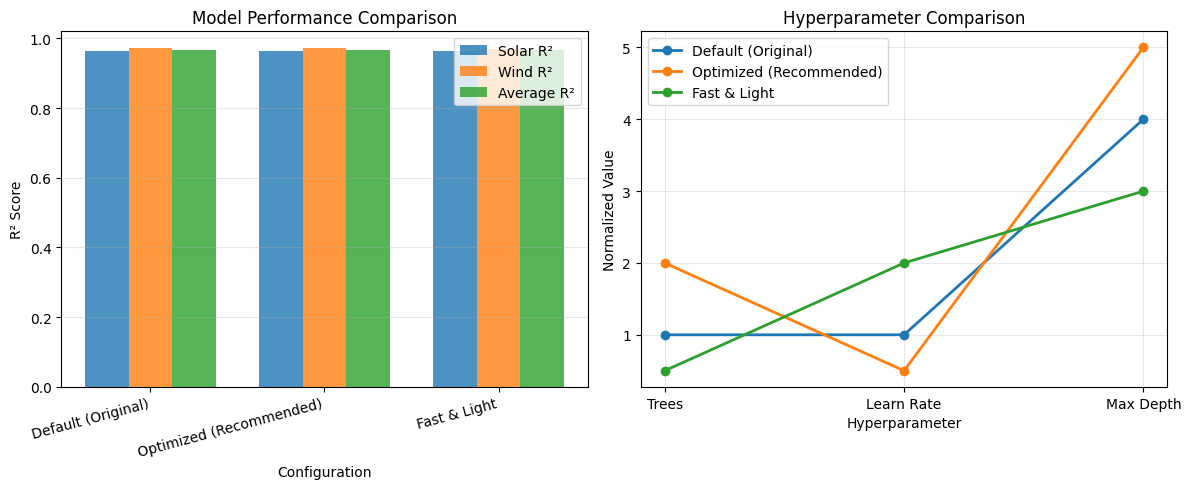

In [19]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ============================================
# PART 1: LOAD DATA AND PREPARE
# ============================================
print("="*60)
print("K-FOLD CROSS VALIDATION FOR ENERGY PREDICTION")
print("="*60)

df = pd.read_csv('final_energy_dataset_2.csv')

# Define Features and Targets
features = [
    'Temperature', 'Humidity', 'Light', 'HumidityRatio',
    'light_out', 'humidity_solar_out', 'temperature_out',
    'wind_speed_out', 'atmp_out', 'humidity_wind_out',
    'Occupancy', 'main'
]

X = df[features]
y_reg = df[['solar_output', 'wind_output']]

# ============================================
# PART 2: HYPERPARAMETER COMPARISON
# ============================================
print("\n" + "="*60)
print("TESTING DIFFERENT HYPERPARAMETERS")
print("="*60)

# Define different hyperparameter configurations
param_configs = [
    {
        'name': 'Default (Original)',
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 4,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'subsample': 1.0
    },
    {
        'name': 'Optimized (Recommended)',
        'n_estimators': 200,
        'learning_rate': 0.05,
        'max_depth': 5,
        'min_samples_split': 10,
        'min_samples_leaf': 4,
        'subsample': 0.8
    },
    {
        'name': 'Fast & Light',
        'n_estimators': 50,
        'learning_rate': 0.2,
        'max_depth': 3,
        'min_samples_split': 20,
        'min_samples_leaf': 10,
        'subsample': 0.8
    }
]

# Store results for comparison
config_results = []

for config in param_configs:
    print(f"\nTesting: {config['name']}")
    print("-" * 60)

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    solar_scores = []
    wind_scores = []

    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y_reg.iloc[train_idx], y_reg.iloc[val_idx]

        model = MultiOutputRegressor(GradientBoostingRegressor(
            n_estimators=config['n_estimators'],
            learning_rate=config['learning_rate'],
            max_depth=config['max_depth'],
            min_samples_split=config['min_samples_split'],
            min_samples_leaf=config['min_samples_leaf'],
            subsample=config['subsample'],
            random_state=42
        ))
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        solar_r2 = r2_score(y_val['solar_output'], y_pred[:, 0])
        wind_r2 = r2_score(y_val['wind_output'], y_pred[:, 1])

        solar_scores.append(solar_r2)
        wind_scores.append(wind_r2)

    avg_solar_r2 = np.mean(solar_scores)
    avg_wind_r2 = np.mean(wind_scores)
    avg_total_r2 = (avg_solar_r2 + avg_wind_r2) / 2

    config_results.append({
        'name': config['name'],
        'solar_r2': avg_solar_r2,
        'wind_r2': avg_wind_r2,
        'total_r2': avg_total_r2,
        'config': config
    })

    print(f"  Solar R²: {avg_solar_r2:.4f}")
    print(f"  Wind R²:  {avg_wind_r2:.4f}")
    print(f"  Avg R²:   {avg_total_r2:.4f}")

# Find best configuration
best_config = max(config_results, key=lambda x: x['total_r2'])
print("\n" + "="*60)
print(f"BEST CONFIGURATION: {best_config['name']}")
print("="*60)
print(f"Solar R²: {best_config['solar_r2']:.4f}")
print(f"Wind R²:  {best_config['wind_r2']:.4f}")
print(f"Avg R²:   {best_config['total_r2']:.4f}")

# ============================================
# PART 3: CREATE COMPARISON PLOT
# ============================================
plt.figure(figsize=(12, 5))

# Plot 1: R² Score Comparison
plt.subplot(1, 2, 1)
names = [r['name'] for r in config_results]
solar_scores = [r['solar_r2'] for r in config_results]
wind_scores = [r['wind_r2'] for r in config_results]
avg_scores = [r['total_r2'] for r in config_results]

x = np.arange(len(names))
width = 0.25

plt.bar(x - width, solar_scores, width, label='Solar R²', alpha=0.8)
plt.bar(x, wind_scores, width, label='Wind R²', alpha=0.8)
plt.bar(x + width, avg_scores, width, label='Average R²', alpha=0.8)

plt.xlabel('Configuration')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.xticks(x, names, rotation=15, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Plot 2: Hyperparameter Values
plt.subplot(1, 2, 2)
param_names = ['n_estimators', 'learning_rate', 'max_depth']
param_display = ['Trees', 'Learn Rate', 'Max Depth']

for idx, config_result in enumerate(config_results):
    config = config_result['config']
    values = [
        config['n_estimators'] / 100,  # Normalize for visualization
        config['learning_rate'] * 10,   # Scale up for visibility
        config['max_depth']
    ]
    plt.plot(param_display, values, marker='o', label=config_result['name'], linewidth=2)

plt.xlabel('Hyperparameter')
plt.ylabel('Normalized Value')
plt.title('Hyperparameter Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Comparison plot saved as 'model_comparison.png'")

# ============================================
# PART 4: LEARNING CURVES WITH BEST MODEL
# ============================================
print("\n" + "="*60)
print("GENERATING LEARNING CURVES (Best Model)")
print("="*60)

best_params = best_config['config']
model_for_curve = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    subsample=best_params['subsample'],
    random_state=42
)

# Generate learning curves for Solar
train_sizes, train_scores_solar, val_scores_solar = learning_curve(
    model_for_curve, X, y_reg['solar_output'],
    cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Generate learning curves for Wind
train_sizes, train_scores_wind, val_scores_wind = learning_curve(
    model_for_curve, X, y_reg['wind_output'],
    cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Solar Learning Curve
axes[0].plot(train_sizes, train_scores_solar.mean(axis=1), 'o-', color='blue', label='Training Score')
axes[0].plot(train_sizes, val_scores_solar.mean(axis=1), 'o-', color='red', label='Validation Score')
axes[0].fill_between(train_sizes,
                      train_scores_solar.mean(axis=1) - train_scores_solar.std(axis=1),
                      train_scores_solar.mean(axis=1) + train_scores_solar.std(axis=1),
                      alpha=0.1, color='blue')
axes[0].fill_between(train_sizes,
                      val_scores_solar.mean(axis=1) - val_scores_solar.std(axis=1),
                      val_scores_solar.mean(axis=1) + val_scores_solar.std(axis=1),
                      alpha=0.1, color='red')
axes[0].set_xlabel('Training Set Size')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Learning Curve - Solar Output')
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)

# Wind Learning Curve
axes[1].plot(train_sizes, train_scores_wind.mean(axis=1), 'o-', color='blue', label='Training Score')
axes[1].plot(train_sizes, val_scores_wind.mean(axis=1), 'o-', color='red', label='Validation Score')
axes[1].fill_between(train_sizes,
                      train_scores_wind.mean(axis=1) - train_scores_wind.std(axis=1),
                      train_scores_wind.mean(axis=1) + train_scores_wind.std(axis=1),
                      alpha=0.1, color='blue')
axes[1].fill_between(train_sizes,
                      val_scores_wind.mean(axis=1) - val_scores_wind.std(axis=1),
                      val_scores_wind.mean(axis=1) + val_scores_wind.std(axis=1),
                      alpha=0.1, color='red')
axes[1].set_xlabel('Training Set Size')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Learning Curve - Wind Output')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
print("✓ Learning curves saved as 'learning_curves.png'")

# ============================================
# PART 5: TRAIN FINAL MODEL WITH BEST PARAMS
# ============================================
print("\n" + "="*60)
print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
print("="*60)

final_reg_model = MultiOutputRegressor(GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    subsample=best_params['subsample'],
    random_state=42
))
final_reg_model.fit(X, y_reg)
print("✓ Final model trained with best hyperparameters")

# ============================================
# PART 6: SAVE THE FINAL MODEL
# ============================================
print("\n" + "="*60)
print("SAVING MODEL AND RESULTS")
print("="*60)

joblib.dump(final_reg_model, 'energy_regression_model.pkl')
joblib.dump(best_params, 'best_hyperparameters.pkl')

print("✓ Model saved successfully!")
print("  - energy_regression_model.pkl")
print("  - best_hyperparameters.pkl")
print("  - model_comparison.png")
print("  - learning_curves.png")

print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
for key, value in best_params.items():
    if key != 'name':
        print(f"  {key}: {value}")

# ============================================
# PART 7: ENERGY SOURCE DECISION LOGIC
# ============================================
def decide_energy_source(solar_output, wind_output, mains_demand):
    """
    Decide which renewable energy source(s) to use based on availability and demand.

    Logic:
    - If total renewable >= 1.1 * mains demand: Use renewable energy (with 10% safety margin)
      - If solar alone can meet demand: Use Solar only
      - If wind alone can meet demand: Use Wind only
      - If both needed: Use Both Solar and Wind
    - If total renewable < 1.1 * mains demand: Use Mains (insufficient renewable with safety margin)

    Returns:
        dict with energy_source, solar_used, wind_used, mains_used
    """
    total_renewable = solar_output + wind_output
    required_renewable = mains_demand * 1.1  # 10% safety margin

    if total_renewable >= required_renewable:
        # Sufficient renewable energy available
        if solar_output >= mains_demand:
            # Solar alone can meet demand
            return {
                'energy_source': 'Solar',
                'solar_used': mains_demand,
                'wind_used': 0,
                'mains_used': 0,
                'surplus': total_renewable - mains_demand
            }
        elif wind_output >= mains_demand:
            # Wind alone can meet demand
            return {
                'energy_source': 'Wind',
                'solar_used': 0,
                'wind_used': mains_demand,
                'mains_used': 0,
                'surplus': total_renewable - mains_demand
            }
        else:
            # Both solar and wind needed
            return {
                'energy_source': 'Solar + Wind',
                'solar_used': solar_output,
                'wind_used': wind_output,
                'mains_used': 0,
                'surplus': total_renewable - mains_demand
            }
    else:
        # Insufficient renewable energy
        deficit = mains_demand - total_renewable
        return {
            'energy_source': 'Mains',
            'solar_used': solar_output,
            'wind_used': wind_output,
            'mains_used': deficit,
            'surplus': 0
        }

# ============================================
# PART 8: TEST THE SAVED MODEL
# ============================================
print("\n" + "="*60)
print("TESTING SAVED MODEL WITH SAMPLE INPUTS")
print("="*60)

# Load model
reg_model_loaded = joblib.load('energy_regression_model.pkl')

# Sample test cases
sample_1 = pd.DataFrame({
    'Temperature': [25.0], 'Humidity': [45.0], 'Light': [500.0],
    'HumidityRatio': [0.005], 'light_out': [800.0], 'humidity_solar_out': [350.0],
    'temperature_out': [28.0], 'wind_speed_out': [3.5], 'atmp_out': [1013.0],
    'humidity_wind_out': [140.0], 'Occupancy': [1], 'main': [50.0]
})

sample_2 = pd.DataFrame({
    'Temperature': [18.0], 'Humidity': [70.0], 'Light': [150.0],
    'HumidityRatio': [0.008], 'light_out': [200.0], 'humidity_solar_out': [140.0],
    'temperature_out': [15.0], 'wind_speed_out': [12.0], 'atmp_out': [1008.0],
    'humidity_wind_out': [840.0], 'Occupancy': [3], 'main': [200.0]
})

sample_3 = pd.DataFrame({
    'Temperature': [22.0], 'Humidity': [55.0], 'Light': [0.0],
    'HumidityRatio': [0.006], 'light_out': [0.0], 'humidity_solar_out': [0.0],
    'temperature_out': [20.0], 'wind_speed_out': [1.0], 'atmp_out': [1012.0],
    'humidity_wind_out': [55.0], 'Occupancy': [2], 'main': [180.0]
})

samples = [
    ("High Solar Conditions (Sunny Day)", sample_1),
    ("High Wind Conditions (Windy Day)", sample_2),
    ("Low Renewable (Night, No Wind)", sample_3)
]

for name, sample in samples:
    print(f"\n{name}:")
    print("-" * 60)

    # Predict renewable energy output
    energy_pred = reg_model_loaded.predict(sample)
    solar_pred = energy_pred[0][0]
    wind_pred = energy_pred[0][1]

    # Get the mains demand input value
    mains_demand = sample['main'].values[0]

    # Decide energy source
    decision = decide_energy_source(solar_pred, wind_pred, mains_demand)

    print(f"  Input:")
    print(f"    Mains Demand:       {mains_demand:>8.2f} W")
    print(f"\n  Predicted Generation:")
    print(f"    Solar Output:       {solar_pred:>8.2f} W")
    print(f"    Wind Output:        {wind_pred:>8.2f} W")
    print(f"    Total Renewable:    {solar_pred + wind_pred:>8.2f} W")
    print(f"\n  Energy Decision:")
    print(f"    Energy Source:      {decision['energy_source']}")
    print(f"    Solar Used:         {decision['solar_used']:>8.2f} W")
    print(f"    Wind Used:          {decision['wind_used']:>8.2f} W")
    print(f"    Mains Used:         {decision['mains_used']:>8.2f} W")
    if decision['surplus'] > 0:
        print(f"    Surplus:            {decision['surplus']:>8.2f} W")

# ============================================
# PART 9: PREDICTION FUNCTION
# ============================================
def predict_energy(Temperature, Humidity, Light, HumidityRatio, light_out,
                   humidity_solar_out, temperature_out, wind_speed_out,
                   atmp_out, humidity_wind_out, Occupancy, main):
    """
    Predict energy generation and recommend energy source.

    Returns:
        dict with solar_output, wind_output, total_renewable, energy_decision
    """
    input_data = pd.DataFrame({
        'Temperature': [Temperature], 'Humidity': [Humidity], 'Light': [Light],
        'HumidityRatio': [HumidityRatio], 'light_out': [light_out],
        'humidity_solar_out': [humidity_solar_out], 'temperature_out': [temperature_out],
        'wind_speed_out': [wind_speed_out], 'atmp_out': [atmp_out],
        'humidity_wind_out': [humidity_wind_out], 'Occupancy': [Occupancy], 'main': [main]
    })

    energy_pred = reg_model_loaded.predict(input_data)
    solar_output = energy_pred[0][0]
    wind_output = energy_pred[0][1]

    decision = decide_energy_source(solar_output, wind_output, main)

    result = {
        'solar_output': solar_output,
        'wind_output': wind_output,
        'total_renewable': solar_output + wind_output,
        'mains_demand': main,
        'energy_decision': decision
    }
    return result

print("\n" + "="*60)
print("HYPERPARAMETER OPTIMIZATION COMPLETE!")
print("="*60)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import joblib

# ============================================
# LOAD DATA AND MODEL
# ============================================
print("Loading data and model...")
df = pd.read_csv('final_energy_dataset_2.csv')

features = [
    'Temperature', 'Humidity', 'Light', 'HumidityRatio',
    'light_out', 'humidity_solar_out', 'temperature_out',
    'wind_speed_out', 'atmp_out', 'humidity_wind_out',
    'Occupancy', 'main'
]

X = df[features]
y_solar = df['solar_output']
y_wind = df['wind_output']

# Load the trained model (or use best hyperparameters)
try:
    best_params = joblib.load('best_hyperparameters.pkl')
    print("✓ Loaded saved hyperparameters")
except:
    print("⚠ Using default hyperparameters")
    best_params = {
        'n_estimators': 200,
        'learning_rate': 0.05,
        'max_depth': 5,
        'min_samples_split': 10,
        'min_samples_leaf': 4,
        'subsample': 0.8
    }

# ============================================
# PLOT 1: LEARNING CURVES
# ============================================
print("\n[1] Generating Learning Curves...")

model = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    subsample=best_params['subsample'],
    random_state=42
)

# Generate learning curves for Solar
train_sizes, train_scores_solar, val_scores_solar = learning_curve(
    model, X, y_solar,
    cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Generate learning curves for Wind
train_sizes, train_scores_wind, val_scores_wind = learning_curve(
    model, X, y_wind,
    cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Solar Learning Curve
axes[0].plot(train_sizes, train_scores_solar.mean(axis=1), 'o-',
             color='#FF6B35', linewidth=2, markersize=8, label='Training Score')
axes[0].plot(train_sizes, val_scores_solar.mean(axis=1), 'o-',
             color='#004E89', linewidth=2, markersize=8, label='Validation Score')
axes[0].fill_between(train_sizes,
                      train_scores_solar.mean(axis=1) - train_scores_solar.std(axis=1),
                      train_scores_solar.mean(axis=1) + train_scores_solar.std(axis=1),
                      alpha=0.15, color='#FF6B35')
axes[0].fill_between(train_sizes,
                      val_scores_solar.mean(axis=1) - val_scores_solar.std(axis=1),
                      val_scores_solar.mean(axis=1) + val_scores_solar.std(axis=1),
                      alpha=0.15, color='#004E89')
axes[0].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Learning Curve - Solar Output', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 1.05])

# Wind Learning Curve
axes[1].plot(train_sizes, train_scores_wind.mean(axis=1), 'o-',
             color='#FF6B35', linewidth=2, markersize=8, label='Training Score')
axes[1].plot(train_sizes, val_scores_wind.mean(axis=1), 'o-',
             color='#004E89', linewidth=2, markersize=8, label='Validation Score')
axes[1].fill_between(train_sizes,
                      train_scores_wind.mean(axis=1) - train_scores_wind.std(axis=1),
                      train_scores_wind.mean(axis=1) + train_scores_wind.std(axis=1),
                      alpha=0.15, color='#FF6B35')
axes[1].fill_between(train_sizes,
                      val_scores_wind.mean(axis=1) - val_scores_wind.std(axis=1),
                      val_scores_wind.mean(axis=1) + val_scores_wind.std(axis=1),
                      alpha=0.15, color='#004E89')
axes[1].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('Learning Curve - Wind Output', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
print("✓ Learning curves saved as 'learning_curves.png'")
plt.show()

# ============================================
# PLOT 2: HYPERPARAMETER SENSITIVITY
# ============================================
print("\n[2] Generating Hyperparameter Sensitivity Analysis...")

from sklearn.model_selection import cross_val_score

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Test different values for each hyperparameter
params_to_test = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}

param_names = list(params_to_test.keys())
for idx, (param_name, param_values) in enumerate(params_to_test.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    scores = []
    for value in param_values:
        # Create model with varying parameter
        params = best_params.copy()
        params[param_name] = value

        model = GradientBoostingRegressor(
            n_estimators=params['n_estimators'],
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            subsample=params['subsample'],
            random_state=42
        )

        # Cross-validate on solar output
        cv_scores = cross_val_score(model, X, y_solar, cv=3, scoring='r2', n_jobs=-1)
        scores.append(cv_scores.mean())

    # Plot
    ax.plot(param_values, scores, 'o-', linewidth=2, markersize=8, color='#1A936F')
    ax.axvline(x=best_params[param_name], color='red', linestyle='--',
               linewidth=2, label=f'Best: {best_params[param_name]}')
    ax.set_xlabel(param_name, fontsize=11, fontweight='bold')
    ax.set_ylabel('R² Score', fontsize=11, fontweight='bold')
    ax.set_title(f'Impact of {param_name}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('hyperparameter_sensitivity.png', dpi=300, bbox_inches='tight')
print("✓ Hyperparameter sensitivity saved as 'hyperparameter_sensitivity.png'")
plt.show()

# ============================================
# PLOT 3: PREDICTION VS ACTUAL
# ============================================
print("\n[3] Generating Prediction vs Actual Plots...")

# Train model on full dataset
final_model = MultiOutputRegressor(GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    subsample=best_params['subsample'],
    random_state=42
))
final_model.fit(X, df[['solar_output', 'wind_output']])

# Make predictions
predictions = final_model.predict(X)
solar_pred = predictions[:, 0]
wind_pred = predictions[:, 1]

# Sample subset for clearer visualization
sample_size = min(1000, len(df))
sample_idx = np.random.choice(len(df), sample_size, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Solar: Predicted vs Actual
axes[0].scatter(y_solar.iloc[sample_idx], solar_pred[sample_idx],
                alpha=0.5, s=30, color='#FF6B35', edgecolors='black', linewidth=0.5)
axes[0].plot([y_solar.min(), y_solar.max()], [y_solar.min(), y_solar.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Solar Output (W)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Solar Output (W)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Solar: Predicted vs Actual\nR² = {r2_score(y_solar, solar_pred):.4f}',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3, linestyle='--')

# Wind: Predicted vs Actual
axes[1].scatter(y_wind.iloc[sample_idx], wind_pred[sample_idx],
                alpha=0.5, s=30, color='#004E89', edgecolors='black', linewidth=0.5)
axes[1].plot([y_wind.min(), y_wind.max()], [y_wind.min(), y_wind.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Wind Output (W)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Wind Output (W)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Wind: Predicted vs Actual\nR² = {r2_score(y_wind, wind_pred):.4f}',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('prediction_vs_actual.png', dpi=300, bbox_inches='tight')
print("✓ Prediction vs Actual saved as 'prediction_vs_actual.png'")
plt.show()

# ============================================
# PLOT 4: RESIDUAL ANALYSIS
# ============================================
print("\n[4] Generating Residual Analysis...")

solar_residuals = y_solar - solar_pred
wind_residuals = y_wind - wind_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Solar Residuals vs Predicted
axes[0, 0].scatter(solar_pred[sample_idx], solar_residuals.iloc[sample_idx],
                   alpha=0.5, s=30, color='#FF6B35', edgecolors='black', linewidth=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Solar Output (W)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals (W)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Solar: Residual Plot', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3, linestyle='--')

# Solar Residual Distribution
axes[0, 1].hist(solar_residuals, bins=50, color='#FF6B35', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals (W)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Solar: Residual Distribution\nMean={solar_residuals.mean():.2f}, Std={solar_residuals.std():.2f}',
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3, linestyle='--')

# Wind Residuals vs Predicted
axes[1, 0].scatter(wind_pred[sample_idx], wind_residuals.iloc[sample_idx],
                   alpha=0.5, s=30, color='#004E89', edgecolors='black', linewidth=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Wind Output (W)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Residuals (W)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Wind: Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, linestyle='--')

# Wind Residual Distribution
axes[1, 1].hist(wind_residuals, bins=50, color='#004E89', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals (W)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title(f'Wind: Residual Distribution\nMean={wind_residuals.mean():.2f}, Std={wind_residuals.std():.2f}',
                     fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Residual analysis saved as 'residual_analysis.png'")
plt.show()

# ============================================
# PLOT 5: FEATURE IMPORTANCE
# ============================================
print("\n[5] Generating Feature Importance Plot...")

# Get feature importances from both models
solar_model = final_model.estimators_[0]
wind_model = final_model.estimators_[1]

solar_importance = solar_model.feature_importances_
wind_importance = wind_model.feature_importances_

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Solar Importance': solar_importance,
    'Wind Importance': wind_importance
})
importance_df = importance_df.sort_values('Solar Importance', ascending=False)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Solar Feature Importance
axes[0].barh(importance_df['Feature'], importance_df['Solar Importance'],
             color='#FF6B35', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[0].set_title('Feature Importance - Solar Output', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# Wind Feature Importance
importance_df_wind = importance_df.sort_values('Wind Importance', ascending=False)
axes[1].barh(importance_df_wind['Feature'], importance_df_wind['Wind Importance'],
             color='#004E89', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[1].set_title('Feature Importance - Wind Output', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Feature importance saved as 'feature_importance.png'")
plt.show()

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*60)
print("ALL PLOTS GENERATED SUCCESSFULLY!")
print("="*60)
print("\nGenerated files:")
print("  1. learning_curves.png - Shows training vs validation performance")
print("  2. hyperparameter_sensitivity.png - Impact of each hyperparameter")
print("  3. prediction_vs_actual.png - How well predictions match reality")
print("  4. residual_analysis.png - Error distribution and patterns")
print("  5. feature_importance.png - Which features matter most")
print("\n" + "="*60)

Loading data and model...
⚠ Using default hyperparameters

[1] Generating Learning Curves...


KeyboardInterrupt: 

In [21]:
import pandas as pd
import numpy as np
import json
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import _tree

# ============================================
# PART 1: LOAD DATA AND TRAIN MODEL
# ============================================
print("="*60)
print("TRAINING MODEL AND EXPORTING TO JSON")
print("="*60)

# Load data
df = pd.read_csv('final_energy_dataset_2.csv')

features = [
    'Temperature', 'Humidity', 'Light', 'HumidityRatio',
    'light_out', 'humidity_solar_out', 'temperature_out',
    'wind_speed_out', 'atmp_out', 'humidity_wind_out',
    'Occupancy', 'main'
]

X = df[features]
y_reg = df[['solar_output', 'wind_output']]

# ============================================
# REFINED HYPERPARAMETERS (BEST CONFIGURATION)
# ============================================
optimized_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'subsample': 0.8,
    'random_state': 42
}

print("\n[1] Training model with optimized hyperparameters...")
print("-"*60)
for key, value in optimized_params.items():
    print(f"  {key}: {value}")

# Train the model
model = MultiOutputRegressor(GradientBoostingRegressor(**optimized_params))
model.fit(X, y_reg)
print("\n✓ Model trained successfully!")

# ============================================
# PART 2: EXTRACT TREE STRUCTURE
# ============================================
def tree_to_dict(tree, feature_names):
    """
    Convert a decision tree to a dictionary representation.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree_.feature
    ]

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            # Internal node
            name = feature_name[node]
            threshold = float(tree_.threshold[node])
            return {
                'type': 'split',
                'feature': name,
                'threshold': threshold,
                'left': recurse(tree_.children_left[node]),
                'right': recurse(tree_.children_right[node])
            }
        else:
            # Leaf node
            return {
                'type': 'leaf',
                'value': float(tree_.value[node][0])
            }

    return recurse(0)

# ============================================
# PART 3: EXTRACT MODEL PARAMETERS
# ============================================
print("\n[2] Extracting model structure to JSON...")

model_json = {
    'model_type': 'GradientBoostingRegressor',
    'framework': 'MultiOutputRegressor',
    'hyperparameters': optimized_params,
    'feature_names': features,
    'outputs': ['solar_output', 'wind_output'],
    'models': {}
}

# Extract Solar Model
print("  - Extracting Solar Output model...")
solar_model = model.estimators_[0]
solar_trees = []

for i, tree in enumerate(solar_model.estimators_[:, 0]):
    tree_dict = tree_to_dict(tree, features)
    solar_trees.append({
        'tree_id': i,
        'structure': tree_dict
    })

model_json['models']['solar'] = {
    'n_trees': len(solar_trees),
    'learning_rate': optimized_params['learning_rate'],
    'init_prediction': float(solar_model.init_.constant_[0][0]) if hasattr(solar_model, 'init_') else 0.0,
    'trees': solar_trees
}

# Extract Wind Model
print("  - Extracting Wind Output model...")
wind_model = model.estimators_[1]
wind_trees = []

for i, tree in enumerate(wind_model.estimators_[:, 0]):
    tree_dict = tree_to_dict(tree, features)
    wind_trees.append({
        'tree_id': i,
        'structure': tree_dict
    })

model_json['models']['wind'] = {
    'n_trees': len(wind_trees),
    'learning_rate': optimized_params['learning_rate'],
    'init_prediction': float(wind_model.init_.constant_[0][0]) if hasattr(wind_model, 'init_') else 0.0,
    'trees': wind_trees
}

# ============================================
# PART 4: ADD FEATURE IMPORTANCE
# ============================================
print("  - Adding feature importance...")

model_json['feature_importance'] = {
    'solar': {
        feature: float(importance)
        for feature, importance in zip(features, solar_model.feature_importances_)
    },
    'wind': {
        feature: float(importance)
        for feature, importance in zip(features, wind_model.feature_importances_)
    }
}

# ============================================
# PART 5: ADD PREDICTION FUNCTION (PSEUDOCODE)
# ============================================
model_json['prediction_logic'] = {
    'description': 'Gradient Boosting prediction formula',
    'formula': 'prediction = init_prediction + learning_rate * sum(tree_predictions)',
    'steps': [
        '1. Start with init_prediction',
        '2. For each tree, traverse from root to leaf based on feature values',
        '3. Multiply leaf value by learning_rate',
        '4. Sum all tree predictions',
        '5. Add to init_prediction'
    ]
}

# ============================================
# PART 6: ADD ENERGY DECISION LOGIC
# ============================================
model_json['energy_decision_logic'] = {
    'description': 'Logic to decide which energy source to use',
    'safety_margin': 1.1,
    'rules': [
        {
            'condition': 'total_renewable >= 1.1 * mains_demand AND solar >= mains_demand',
            'decision': 'Use Solar only'
        },
        {
            'condition': 'total_renewable >= 1.1 * mains_demand AND wind >= mains_demand',
            'decision': 'Use Wind only'
        },
        {
            'condition': 'total_renewable >= 1.1 * mains_demand AND solar < mains_demand AND wind < mains_demand',
            'decision': 'Use Solar + Wind'
        },
        {
            'condition': 'total_renewable < 1.1 * mains_demand',
            'decision': 'Use Mains (with available renewable)'
        }
    ]
}

# ============================================
# PART 7: SAVE TO JSON FILES
# ============================================
print("\n[3] Saving JSON files...")

# Save full model (WARNING: Can be very large!)
with open('energy_model_full.json', 'w') as f:
    json.dump(model_json, f, indent=2)
print("✓ Full model saved as 'energy_model_full.json'")

# Save lightweight version (without tree structures)
lightweight_json = {
    'model_type': model_json['model_type'],
    'framework': model_json['framework'],
    'hyperparameters': model_json['hyperparameters'],
    'feature_names': model_json['feature_names'],
    'outputs': model_json['outputs'],
    'feature_importance': model_json['feature_importance'],
    'prediction_logic': model_json['prediction_logic'],
    'energy_decision_logic': model_json['energy_decision_logic'],
    'models_summary': {
        'solar': {
            'n_trees': model_json['models']['solar']['n_trees'],
            'learning_rate': model_json['models']['solar']['learning_rate'],
            'init_prediction': model_json['models']['solar']['init_prediction']
        },
        'wind': {
            'n_trees': model_json['models']['wind']['n_trees'],
            'learning_rate': model_json['models']['wind']['learning_rate'],
            'init_prediction': model_json['models']['wind']['init_prediction']
        }
    }
}

with open('energy_model_lightweight.json', 'w') as f:
    json.dump(lightweight_json, f, indent=2)
print("✓ Lightweight model saved as 'energy_model_lightweight.json'")

# Save only hyperparameters and metadata
metadata_json = {
    'model_info': {
        'type': 'Gradient Boosting Regressor',
        'outputs': ['solar_output', 'wind_output'],
        'framework': 'scikit-learn MultiOutputRegressor'
    },
    'hyperparameters': optimized_params,
    'features': {
        'input_features': features,
        'feature_count': len(features)
    },
    'training_info': {
        'dataset_size': len(df),
        'cross_validation': '5-fold'
    }
}

with open('energy_model_metadata.json', 'w') as f:
    json.dump(metadata_json, f, indent=2)
print("✓ Metadata saved as 'energy_model_metadata.json'")

# ============================================
# PART 8: SAVE TRADITIONAL MODEL FILES
# ============================================
print("\n[4] Saving traditional model files...")

joblib.dump(model, 'energy_regression_model.pkl')
joblib.dump(optimized_params, 'best_hyperparameters.pkl')

print("✓ Model saved as 'energy_regression_model.pkl'")
print("✓ Hyperparameters saved as 'best_hyperparameters.pkl'")

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*60)
print("MODEL EXPORT COMPLETE!")
print("="*60)
print("\nGenerated files:")
print("  1. energy_model_full.json - Complete model with all tree structures")
print("     (WARNING: Very large file ~50-100MB)")
print("  2. energy_model_lightweight.json - Model without tree structures")
print("     (Recommended for documentation and API specs)")
print("  3. energy_model_metadata.json - Just hyperparameters and metadata")
print("     (Smallest, good for quick reference)")
print("  4. energy_regression_model.pkl - Traditional scikit-learn format")
print("  5. best_hyperparameters.pkl - Just the hyperparameters")

print("\n" + "="*60)
print("OPTIMIZED HYPERPARAMETERS USED:")
print("="*60)
for key, value in optimized_params.items():
    print(f"  {key}: {value}")

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Top 5):")
print("="*60)

solar_importance = sorted(
    model_json['feature_importance']['solar'].items(),
    key=lambda x: x[1],
    reverse=True
)[:5]
print("\nSolar Model:")
for feature, importance in solar_importance:
    print(f"  {feature}: {importance:.4f}")

wind_importance = sorted(
    model_json['feature_importance']['wind'].items(),
    key=lambda x: x[1],
    reverse=True
)[:5]
print("\nWind Model:")
for feature, importance in wind_importance:
    print(f"  {feature}: {importance:.4f}")

print("\n" + "="*60)

TRAINING MODEL AND EXPORTING TO JSON

[1] Training model with optimized hyperparameters...
------------------------------------------------------------
  n_estimators: 200
  learning_rate: 0.05
  max_depth: 5
  min_samples_split: 10
  min_samples_leaf: 4
  subsample: 0.8
  random_state: 42

✓ Model trained successfully!

[2] Extracting model structure to JSON...
  - Extracting Solar Output model...
  - Extracting Wind Output model...
  - Adding feature importance...

[3] Saving JSON files...


/tmp/ipython-input-920777344.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'value': float(tree_.value[node][0])


✓ Full model saved as 'energy_model_full.json'
✓ Lightweight model saved as 'energy_model_lightweight.json'
✓ Metadata saved as 'energy_model_metadata.json'

[4] Saving traditional model files...
✓ Model saved as 'energy_regression_model.pkl'
✓ Hyperparameters saved as 'best_hyperparameters.pkl'

MODEL EXPORT COMPLETE!

Generated files:
  1. energy_model_full.json - Complete model with all tree structures
     (WARNING: Very large file ~50-100MB)
  2. energy_model_lightweight.json - Model without tree structures
     (Recommended for documentation and API specs)
  3. energy_model_metadata.json - Just hyperparameters and metadata
     (Smallest, good for quick reference)
  4. energy_regression_model.pkl - Traditional scikit-learn format
  5. best_hyperparameters.pkl - Just the hyperparameters

OPTIMIZED HYPERPARAMETERS USED:
  n_estimators: 200
  learning_rate: 0.05
  max_depth: 5
  min_samples_split: 10
  min_samples_leaf: 4
  subsample: 0.8
  random_state: 42

FEATURE IMPORTANCE (Top 

In [23]:
pip install skl2onnx onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.0 MB/s eta 0:00:00


In [26]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx
import onnxruntime as ort

# ============================================
# PART 1: INSTALL REQUIRED PACKAGES
# ============================================
print("="*60)
print("CONVERTING MODEL TO ONNX FORMAT")
print("="*60)
print("\nNOTE: If not installed, run:")
print("  pip install skl2onnx onnx onnxruntime")
print("="*60)

# ============================================
# PART 2: LOAD OR TRAIN MODEL
# ============================================
print("\n[1] Loading/Training model...")

# Load data
df = pd.read_csv('final_energy_dataset_2.csv')

features = [
    'Temperature', 'Humidity', 'Light', 'HumidityRatio',
    'light_out', 'humidity_solar_out', 'temperature_out',
    'wind_speed_out', 'atmp_out', 'humidity_wind_out',
    'Occupancy', 'main'
]

X = df[features]
y_reg = df[['solar_output', 'wind_output']]

# Refined hyperparameters
best_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'subsample': 0.8,
    'random_state': 42
}

# Try to load existing model, otherwise train new one
try:
    model = joblib.load('energy_regression_model.pkl')
    print("✓ Loaded existing model from 'energy_regression_model.pkl'")
except:
    print("  Training new model with optimized parameters...")
    model = MultiOutputRegressor(GradientBoostingRegressor(**best_params))
    model.fit(X, y_reg)
    joblib.dump(model, 'energy_regression_model.pkl')
    print("✓ Model trained and saved")

# ============================================
# PART 3: CONVERT TO ONNX
# ============================================
print("\n[2] Converting to ONNX format...")

# Define input type (shape: [None, 12] means batch size can vary, 12 features)
initial_type = [('float_input', FloatTensorType([None, len(features)]))]

# Convert to ONNX
onnx_model = convert_sklearn(
    model,
    initial_types=initial_type,
    target_opset=12  # ONNX opset version
)

# Save ONNX model
onnx_file = 'energy_regression_model.onnx'
with open(onnx_file, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"✓ ONNX model saved as '{onnx_file}'")

# Get model size
import os
onnx_size = os.path.getsize(onnx_file) / (1024 * 1024)  # Convert to MB
pkl_size = os.path.getsize('energy_regression_model.pkl') / (1024 * 1024)

print(f"\n  Model Sizes:")
print(f"    PKL file:  {pkl_size:.2f} MB")
print(f"    ONNX file: {onnx_size:.2f} MB")

# ============================================
# PART 4: VERIFY ONNX MODEL
# ============================================
print("\n[3] Verifying ONNX model...")

# Check if ONNX model is valid
try:
    onnx.checker.check_model(onnx_model)
    print("✓ ONNX model is valid")
except Exception as e:
    print(f"✗ ONNX model validation failed: {e}")

# Print model info
print("\n  ONNX Model Info:")
print(f"    IR Version: {onnx_model.ir_version}")
print(f"    Producer: {onnx_model.producer_name} {onnx_model.producer_version}")
print(f"    Opset Version: {onnx_model.opset_import[0].version}")

# Print input/output info
print("\n  Inputs:")
for input_tensor in onnx_model.graph.input:
    print(f"    - {input_tensor.name}: {input_tensor.type}")

print("\n  Outputs:")
for output_tensor in onnx_model.graph.output:
    print(f"    - {output_tensor.name}: {output_tensor.type}")

# ============================================
# PART 5: TEST ONNX MODEL
# ============================================
print("\n[4] Testing ONNX model predictions...")

# Create ONNX Runtime session
ort_session = ort.InferenceSession(onnx_file)

# Prepare test data
test_samples = [
    {
        'name': 'High Solar (Sunny Day)',
        'data': np.array([[25.0, 45.0, 500.0, 0.005, 800.0, 350.0,
                          28.0, 3.5, 1013.0, 140.0, 1, 50.0]], dtype=np.float32)
    },
    {
        'name': 'High Wind (Windy Day)',
        'data': np.array([[18.0, 70.0, 150.0, 0.008, 200.0, 140.0,
                          15.0, 12.0, 1008.0, 840.0, 3, 200.0]], dtype=np.float32)
    },
    {
        'name': 'Low Renewable (Night)',
        'data': np.array([[22.0, 55.0, 0.0, 0.006, 0.0, 0.0,
                          20.0, 1.0, 1012.0, 55.0, 2, 180.0]], dtype=np.float32)
    }
]

print("\nComparing predictions: scikit-learn vs ONNX")
print("-" * 60)

for sample in test_samples:
    # scikit-learn prediction
    sklearn_pred = model.predict(sample['data'])

    # ONNX prediction
    onnx_input = {ort_session.get_inputs()[0].name: sample['data']}
    onnx_pred = ort_session.run(None, onnx_input)[0]

    # Compare
    solar_sklearn = sklearn_pred[0][0]
    wind_sklearn = sklearn_pred[0][1]
    solar_onnx = onnx_pred[0][0]
    wind_onnx = onnx_pred[0][1]

    solar_diff = abs(solar_sklearn - solar_onnx)
    wind_diff = abs(wind_sklearn - wind_onnx)

    print(f"\n{sample['name']}:")
    print(f"  Solar Output:")
    print(f"    scikit-learn: {solar_sklearn:>8.2f} W")
    print(f"    ONNX:         {solar_onnx:>8.2f} W")
    print(f"    Difference:   {solar_diff:>8.4f} W")
    print(f"  Wind Output:")
    print(f"    scikit-learn: {wind_sklearn:>8.2f} W")
    print(f"    ONNX:         {wind_onnx:>8.2f} W")
    print(f"    Difference:   {wind_diff:>8.4f} W")

# ============================================
# PART 6: BENCHMARK PERFORMANCE
# ============================================
print("\n[5] Benchmarking inference speed...")

import time

# Prepare batch of test data
batch_size = 100
test_batch = np.random.randn(batch_size, len(features)).astype(np.float32)

# Benchmark scikit-learn
start = time.time()
for _ in range(100):
    _ = model.predict(test_batch)
sklearn_time = (time.time() - start) / 100

# Benchmark ONNX
onnx_input = {ort_session.get_inputs()[0].name: test_batch}
start = time.time()
for _ in range(100):
    _ = ort_session.run(None, onnx_input)
onnx_time = (time.time() - start) / 100

print(f"\n  Average inference time (batch of {batch_size}):")
print(f"    scikit-learn: {sklearn_time*1000:.2f} ms")
print(f"    ONNX:         {onnx_time*1000:.2f} ms")
print(f"    Speedup:      {sklearn_time/onnx_time:.2f}x")

# ============================================
# PART 7: SAVE ONNX METADATA
# ============================================
print("\n[6] Saving ONNX metadata...")

metadata = {
    'model_name': 'Energy Prediction Model',
    'version': '1.0',
    'description': 'Gradient Boosting model for predicting solar and wind energy output',
    'features': features,
    'outputs': ['solar_output', 'wind_output'],
    'hyperparameters': best_params,
    'input_shape': [None, len(features)],
    'output_shape': [None, 2],
    'onnx_opset': 12,
    'framework': 'scikit-learn',
    'converter': 'skl2onnx'
}

import json
with open('onnx_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Metadata saved as 'onnx_model_metadata.json'")

# ============================================
# PART 8: USAGE EXAMPLES
# ============================================
print("\n" + "="*60)
print("ONNX CONVERSION COMPLETE!")
print("="*60)

print("\n" + "="*60)
print("HOW TO USE THE ONNX MODEL")
print("="*60)

usage_code = '''
# Python Example
import onnxruntime as ort
import numpy as np

# Load model
session = ort.InferenceSession('energy_regression_model.onnx')

# Prepare input (12 features)
input_data = np.array([[
    25.0,   # Temperature
    45.0,   # Humidity
    500.0,  # Light
    0.005,  # HumidityRatio
    800.0,  # light_out
    350.0,  # humidity_solar_out
    28.0,   # temperature_out
    3.5,    # wind_speed_out
    1013.0, # atmp_out
    140.0,  # humidity_wind_out
    1,      # Occupancy
    50.0    # main
]], dtype=np.float32)

# Run inference
input_name = session.get_inputs()[0].name
output = session.run(None, {input_name: input_data})

# Get predictions
solar_output = output[0][0][0]
wind_output = output[0][0][1]

print(f"Solar: {solar_output:.2f} W")
print(f"Wind: {wind_output:.2f} W")
'''

print(usage_code)

print("\n" + "="*60)
print("BENEFITS OF ONNX FORMAT:")
print("="*60)
print("  ✓ Cross-platform: Use in Python, C++, C#, Java, JavaScript")
print("  ✓ Faster inference: Optimized runtime performance")
print("  ✓ Deployment-ready: Easy to deploy in production")
print("  ✓ Hardware acceleration: Can use GPU, NPU, etc.")
print("  ✓ Smaller size: Often more compact than pickle files")
print("  ✓ Interoperable: Works across different ML frameworks")

print("\n" + "="*60)
print("FILES GENERATED:")
print("="*60)
print("  1. energy_regression_model.onnx - ONNX model file")
print("  2. onnx_model_metadata.json - Model metadata")
print("  3. energy_regression_model.pkl - Original scikit-learn model")

print("\n" + "="*60)

CONVERTING MODEL TO ONNX FORMAT

NOTE: If not installed, run:
  pip install skl2onnx onnx onnxruntime

[1] Loading/Training model...
✓ Loaded existing model from 'energy_regression_model.pkl'

[2] Converting to ONNX format...
✓ ONNX model saved as 'energy_regression_model.onnx'

  Model Sizes:
    PKL file:  1.49 MB
    ONNX file: 0.71 MB

[3] Verifying ONNX model...
✓ ONNX model is valid

  ONNX Model Info:
    IR Version: 7
    Producer: skl2onnx 1.19.1
    Opset Version: 12

  Inputs:
    - float_input: tensor_type {
  elem_type: 1
  shape {
    dim {
    }
    dim {
      dim_value: 12
    }
  }
}


  Outputs:
    - variable: tensor_type {
  elem_type: 1
  shape {
    dim {
    }
    dim {
      dim_value: 2
    }
  }
}


[4] Testing ONNX model predictions...

Comparing predictions: scikit-learn vs ONNX
------------------------------------------------------------

High Solar (Sunny Day):
  Solar Output:
    scikit-learn:    78.58 W
    ONNX:            78.58 W
    Difference:     0

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.w


  Average inference time (batch of 100):
    scikit-learn: 3.17 ms
    ONNX:         1.01 ms
    Speedup:      3.14x

[6] Saving ONNX metadata...
✓ Metadata saved as 'onnx_model_metadata.json'

ONNX CONVERSION COMPLETE!

HOW TO USE THE ONNX MODEL

# Python Example
import onnxruntime as ort
import numpy as np

# Load model
session = ort.InferenceSession('energy_regression_model.onnx')

# Prepare input (12 features)
input_data = np.array([[
    25.0,   # Temperature
    45.0,   # Humidity
    500.0,  # Light
    0.005,  # HumidityRatio
    800.0,  # light_out
    350.0,  # humidity_solar_out
    28.0,   # temperature_out
    3.5,    # wind_speed_out
    1013.0, # atmp_out
    140.0,  # humidity_wind_out
    1,      # Occupancy
    50.0    # main
]], dtype=np.float32)

# Run inference
input_name = session.get_inputs()[0].name
output = session.run(None, {input_name: input_data})

# Get predictions
solar_output = output[0][0][0]
wind_output = output[0][0][1]

print(f"Solar: {solar_output:.

In [27]:
import numpy as np
import onnxruntime as ort
import onnx
import time

# ============================================
# PART 1: LOAD ONNX MODEL
# ============================================
print("="*60)
print("TESTING EXISTING ONNX MODEL")
print("="*60)

onnx_file = 'energy_regression_model.onnx'

print(f"\n[1] Loading ONNX model from '{onnx_file}'...")

try:
    # Load and validate ONNX model
    onnx_model = onnx.load(onnx_file)
    onnx.checker.check_model(onnx_model)
    print("✓ ONNX model loaded and validated successfully")

    # Create inference session
    ort_session = ort.InferenceSession(onnx_file)
    print("✓ ONNX Runtime session created")

except FileNotFoundError:
    print(f"✗ Error: File '{onnx_file}' not found!")
    print("  Make sure the ONNX model file is in the current directory")
    exit()
except Exception as e:
    print(f"✗ Error loading model: {e}")
    exit()

# ============================================
# PART 2: MODEL INFORMATION
# ============================================
print("\n[2] Model Information:")
print("-"*60)

# Input information
print("\nInputs:")
for i, input_tensor in enumerate(ort_session.get_inputs()):
    print(f"  {i+1}. Name: {input_tensor.name}")
    print(f"     Shape: {input_tensor.shape}")
    print(f"     Type: {input_tensor.type}")

# Output information
print("\nOutputs:")
for i, output_tensor in enumerate(ort_session.get_outputs()):
    print(f"  {i+1}. Name: {output_tensor.name}")
    print(f"     Shape: {output_tensor.shape}")
    print(f"     Type: {output_tensor.type}")

# ============================================
# PART 3: PREPARE TEST DATA
# ============================================
print("\n[3] Preparing test samples...")

# Feature names for reference
feature_names = [
    'Temperature', 'Humidity', 'Light', 'HumidityRatio',
    'light_out', 'humidity_solar_out', 'temperature_out',
    'wind_speed_out', 'atmp_out', 'humidity_wind_out',
    'Occupancy', 'main'
]

# Test samples
test_samples = [
    {
        'name': 'High Solar Conditions (Sunny Day)',
        'mains_demand': 50.0,
        'data': np.array([[
            25.0,   # Temperature
            45.0,   # Humidity
            500.0,  # Light
            0.005,  # HumidityRatio
            800.0,  # light_out
            350.0,  # humidity_solar_out
            28.0,   # temperature_out
            3.5,    # wind_speed_out
            1013.0, # atmp_out
            140.0,  # humidity_wind_out
            1,      # Occupancy
            50.0    # main
        ]], dtype=np.float32)
    },
    {
        'name': 'High Wind Conditions (Windy Day)',
        'mains_demand': 200.0,
        'data': np.array([[
            18.0,   # Temperature
            70.0,   # Humidity
            150.0,  # Light
            0.008,  # HumidityRatio
            200.0,  # light_out
            140.0,  # humidity_solar_out
            15.0,   # temperature_out
            12.0,   # wind_speed_out
            1008.0, # atmp_out
            840.0,  # humidity_wind_out
            3,      # Occupancy
            200.0   # main
        ]], dtype=np.float32)
    },
    {
        'name': 'Low Renewable (Night, No Wind)',
        'mains_demand': 180.0,
        'data': np.array([[
            22.0,   # Temperature
            55.0,   # Humidity
            0.0,    # Light
            0.006,  # HumidityRatio
            0.0,    # light_out
            0.0,    # humidity_solar_out
            20.0,   # temperature_out
            1.0,    # wind_speed_out
            1012.0, # atmp_out
            55.0,   # humidity_wind_out
            2,      # Occupancy
            180.0   # main
        ]], dtype=np.float32)
    },
    {
        'name': 'Moderate Conditions (Partly Cloudy)',
        'mains_demand': 120.0,
        'data': np.array([[
            23.0,   # Temperature
            50.0,   # Humidity
            300.0,  # Light
            0.006,  # HumidityRatio
            600.0,  # light_out
            300.0,  # humidity_solar_out
            25.0,   # temperature_out
            5.0,    # wind_speed_out
            1011.0, # atmp_out
            250.0,  # humidity_wind_out
            2,      # Occupancy
            120.0   # main
        ]], dtype=np.float32)
    }
]

print(f"✓ Prepared {len(test_samples)} test samples")

# ============================================
# PART 4: ENERGY DECISION FUNCTION
# ============================================
def decide_energy_source(solar_output, wind_output, mains_demand):
    """Decide which energy source to use (1.1x safety margin)"""
    total_renewable = solar_output + wind_output
    required_renewable = mains_demand * 1.1

    if total_renewable >= required_renewable:
        if solar_output >= mains_demand:
            return {
                'source': 'Solar',
                'solar_used': mains_demand,
                'wind_used': 0,
                'mains_used': 0,
                'surplus': total_renewable - mains_demand
            }
        elif wind_output >= mains_demand:
            return {
                'source': 'Wind',
                'solar_used': 0,
                'wind_used': mains_demand,
                'mains_used': 0,
                'surplus': total_renewable - mains_demand
            }
        else:
            return {
                'source': 'Solar + Wind',
                'solar_used': solar_output,
                'wind_used': wind_output,
                'mains_used': 0,
                'surplus': total_renewable - mains_demand
            }
    else:
        deficit = mains_demand - total_renewable
        return {
            'source': 'Mains',
            'solar_used': solar_output,
            'wind_used': wind_output,
            'mains_used': deficit,
            'surplus': 0
        }

# ============================================
# PART 5: RUN PREDICTIONS
# ============================================
print("\n[4] Running predictions...")
print("="*60)

# Get input name for ONNX model
input_name = ort_session.get_inputs()[0].name

for i, sample in enumerate(test_samples, 1):
    print(f"\nTest {i}: {sample['name']}")
    print("-"*60)

    # Run ONNX inference
    onnx_input = {input_name: sample['data']}
    output = ort_session.run(None, onnx_input)

    # Extract predictions
    solar_output = float(output[0][0][0])
    wind_output = float(output[0][0][1])
    total_renewable = solar_output + wind_output

    # Make energy decision
    decision = decide_energy_source(solar_output, wind_output, sample['mains_demand'])

    # Display results
    print(f"\nInput:")
    print(f"  Mains Demand:       {sample['mains_demand']:>8.2f} W")

    print(f"\nPredicted Generation:")
    print(f"  Solar Output:       {solar_output:>8.2f} W")
    print(f"  Wind Output:        {wind_output:>8.2f} W")
    print(f"  Total Renewable:    {total_renewable:>8.2f} W")
    print(f"  Required (1.1x):    {sample['mains_demand']*1.1:>8.2f} W")

    print(f"\nEnergy Decision:")
    print(f"  Energy Source:      {decision['source']}")
    print(f"  Solar Used:         {decision['solar_used']:>8.2f} W")
    print(f"  Wind Used:          {decision['wind_used']:>8.2f} W")
    print(f"  Mains Used:         {decision['mains_used']:>8.2f} W")
    if decision['surplus'] > 0:
        print(f"  Surplus:            {decision['surplus']:>8.2f} W")

# ============================================
# PART 6: BATCH PREDICTION TEST
# ============================================
print("\n" + "="*60)
print("[5] Testing batch prediction...")
print("-"*60)

# Create batch of random test data
batch_size = 10
batch_data = np.random.randn(batch_size, 12).astype(np.float32)

# Normalize to realistic ranges
batch_data[:, 0] = np.clip(batch_data[:, 0] * 5 + 20, 10, 35)    # Temperature
batch_data[:, 1] = np.clip(batch_data[:, 1] * 10 + 50, 30, 80)   # Humidity
batch_data[:, 2] = np.clip(batch_data[:, 2] * 100 + 250, 0, 600) # Light
batch_data[:, 3] = np.clip(batch_data[:, 3] * 0.001 + 0.005, 0.003, 0.009) # HumidityRatio
batch_data[:, 4] = np.clip(batch_data[:, 4] * 150 + 400, 0, 900)  # light_out
batch_data[:, 5] = np.clip(batch_data[:, 5] * 50 + 200, 0, 400)   # humidity_solar_out
batch_data[:, 6] = np.clip(batch_data[:, 6] * 5 + 22, 12, 32)     # temperature_out
batch_data[:, 7] = np.clip(batch_data[:, 7] * 3 + 5, 0, 15)       # wind_speed_out
batch_data[:, 8] = np.clip(batch_data[:, 8] * 5 + 1010, 1000, 1020) # atmp_out
batch_data[:, 9] = np.clip(batch_data[:, 9] * 100 + 300, 50, 900) # humidity_wind_out
batch_data[:, 10] = np.clip(batch_data[:, 10] * 1.5 + 1.5, 0, 3).astype(int) # Occupancy
batch_data[:, 11] = np.clip(batch_data[:, 11] * 50 + 100, 50, 250) # main

# Run batch prediction
batch_input = {input_name: batch_data}
batch_output = ort_session.run(None, batch_input)

print(f"✓ Batch prediction successful!")
print(f"  Input shape:  {batch_data.shape}")
print(f"  Output shape: {batch_output[0].shape}")
print(f"\nFirst 3 predictions from batch:")
for i in range(3):
    print(f"  Sample {i+1}: Solar={batch_output[0][i][0]:.2f}W, Wind={batch_output[0][i][1]:.2f}W")

# ============================================
# PART 7: PERFORMANCE BENCHMARK
# ============================================
print("\n" + "="*60)
print("[6] Performance benchmark...")
print("-"*60)

# Single prediction benchmark
single_data = test_samples[0]['data']
iterations = 1000

start = time.time()
for _ in range(iterations):
    _ = ort_session.run(None, {input_name: single_data})
single_time = (time.time() - start) / iterations

print(f"\nSingle prediction:")
print(f"  Average time: {single_time*1000:.3f} ms")
print(f"  Throughput:   {1/single_time:.0f} predictions/second")

# Batch prediction benchmark
batch_data_bench = np.random.randn(100, 12).astype(np.float32)
iterations = 100

start = time.time()
for _ in range(iterations):
    _ = ort_session.run(None, {input_name: batch_data_bench})
batch_time = (time.time() - start) / iterations

print(f"\nBatch prediction (100 samples):")
print(f"  Average time: {batch_time*1000:.2f} ms")
print(f"  Per sample:   {batch_time*1000/100:.3f} ms")
print(f"  Throughput:   {100/batch_time:.0f} predictions/second")

# ============================================
# PART 8: CUSTOM INPUT FUNCTION
# ============================================
print("\n" + "="*60)
print("[7] Custom prediction function")
print("="*60)

def predict_energy(Temperature, Humidity, Light, HumidityRatio,
                   light_out, humidity_solar_out, temperature_out,
                   wind_speed_out, atmp_out, humidity_wind_out,
                   Occupancy, main):
    """
    Predict energy output using ONNX model.

    Returns:
        dict with predictions and energy decision
    """
    # Prepare input
    input_data = np.array([[
        Temperature, Humidity, Light, HumidityRatio,
        light_out, humidity_solar_out, temperature_out,
        wind_speed_out, atmp_out, humidity_wind_out,
        Occupancy, main
    ]], dtype=np.float32)

    # Run prediction
    output = ort_session.run(None, {input_name: input_data})

    solar = float(output[0][0][0])
    wind = float(output[0][0][1])

    decision = decide_energy_source(solar, wind, main)

    return {
        'solar_output': solar,
        'wind_output': wind,
        'total_renewable': solar + wind,
        'mains_demand': main,
        'energy_decision': decision
    }

# Example usage
print("\nExample: Custom prediction")
result = predict_energy(
    Temperature=23.0, Humidity=50.0, Light=300.0, HumidityRatio=0.006,
    light_out=600.0, humidity_solar_out=300.0, temperature_out=25.0,
    wind_speed_out=5.0, atmp_out=1011.0, humidity_wind_out=250.0,
    Occupancy=2, main=100.0
)

print(f"\n  Mains Demand:    {result['mains_demand']:.2f} W")
print(f"  Solar Output:    {result['solar_output']:.2f} W")
print(f"  Wind Output:     {result['wind_output']:.2f} W")
print(f"  Total Renewable: {result['total_renewable']:.2f} W")
print(f"\n  Energy Source:   {result['energy_decision']['source']}")
print(f"  Solar Used:      {result['energy_decision']['solar_used']:.2f} W")
print(f"  Wind Used:       {result['energy_decision']['wind_used']:.2f} W")
print(f"  Mains Used:      {result['energy_decision']['mains_used']:.2f} W")
if result['energy_decision']['surplus'] > 0:
    print(f"  Surplus:         {result['energy_decision']['surplus']:.2f} W")

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*60)
print("ONNX MODEL TESTING COMPLETE!")
print("="*60)
print("\n✓ Model loaded and validated")
print("✓ Single predictions working")
print("✓ Batch predictions working")
print("✓ Performance benchmarked")
print("✓ Custom function ready to use")
print("\n" + "="*60)

TESTING EXISTING ONNX MODEL

[1] Loading ONNX model from 'energy_regression_model.onnx'...
✓ ONNX model loaded and validated successfully
✓ ONNX Runtime session created

[2] Model Information:
------------------------------------------------------------

Inputs:
  1. Name: float_input
     Shape: [None, 12]
     Type: tensor(float)

Outputs:
  1. Name: variable
     Shape: [None, 2]
     Type: tensor(float)

[3] Preparing test samples...
✓ Prepared 4 test samples

[4] Running predictions...

Test 1: High Solar Conditions (Sunny Day)
------------------------------------------------------------

Input:
  Mains Demand:          50.00 W

Predicted Generation:
  Solar Output:          78.58 W
  Wind Output:          155.22 W
  Total Renewable:      233.80 W
  Required (1.1x):       55.00 W

Energy Decision:
  Energy Source:      Solar
  Solar Used:            50.00 W
  Wind Used:              0.00 W
  Mains Used:             0.00 W
  Surplus:              183.80 W

Test 2: High Wind Conditi

GENERATING PLOTS FOR ONNX MODEL (Colab Optimized)

[1] Loading ONNX model...
✓ ONNX model loaded from 'energy_regression_model.onnx'

[2] Loading dataset...
✓ Dataset loaded: 8143 samples

[3] Making predictions with ONNX model...
✓ Predictions complete
  Solar R²: 0.9745
  Wind R²:  0.9813

[4] Generating Plot 1: Prediction vs Actual...


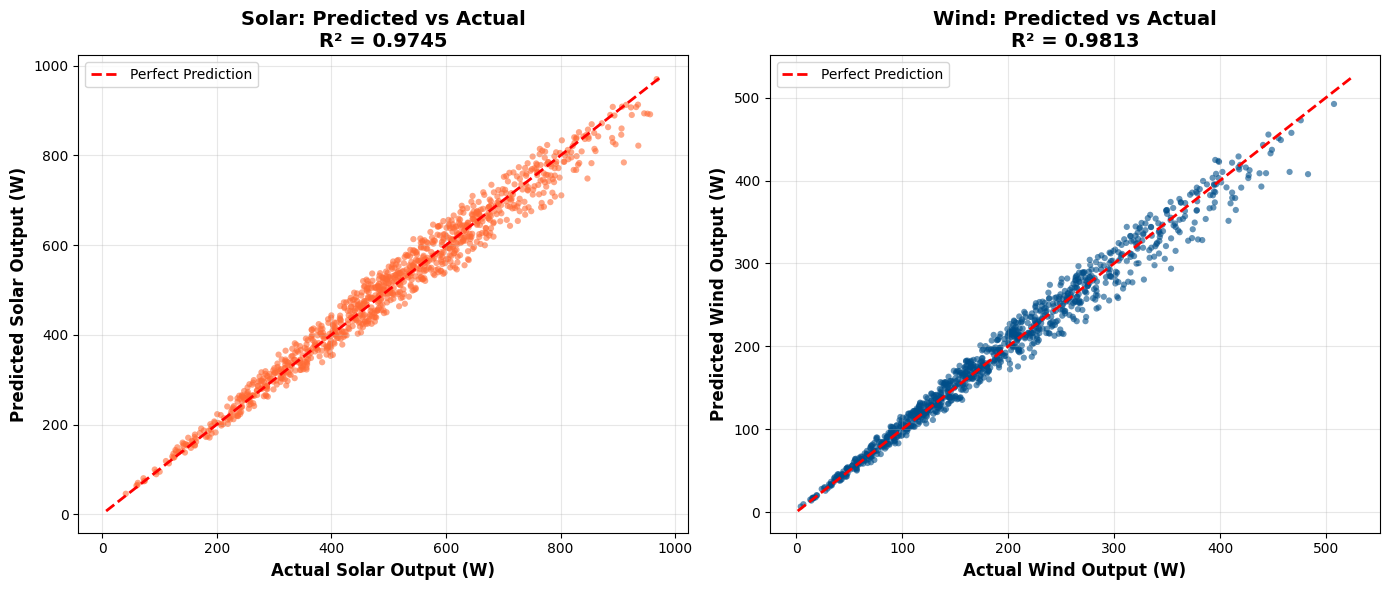

✓ Saved: onnx_prediction_vs_actual.png

[5] Generating Plot 2: Residual Analysis...


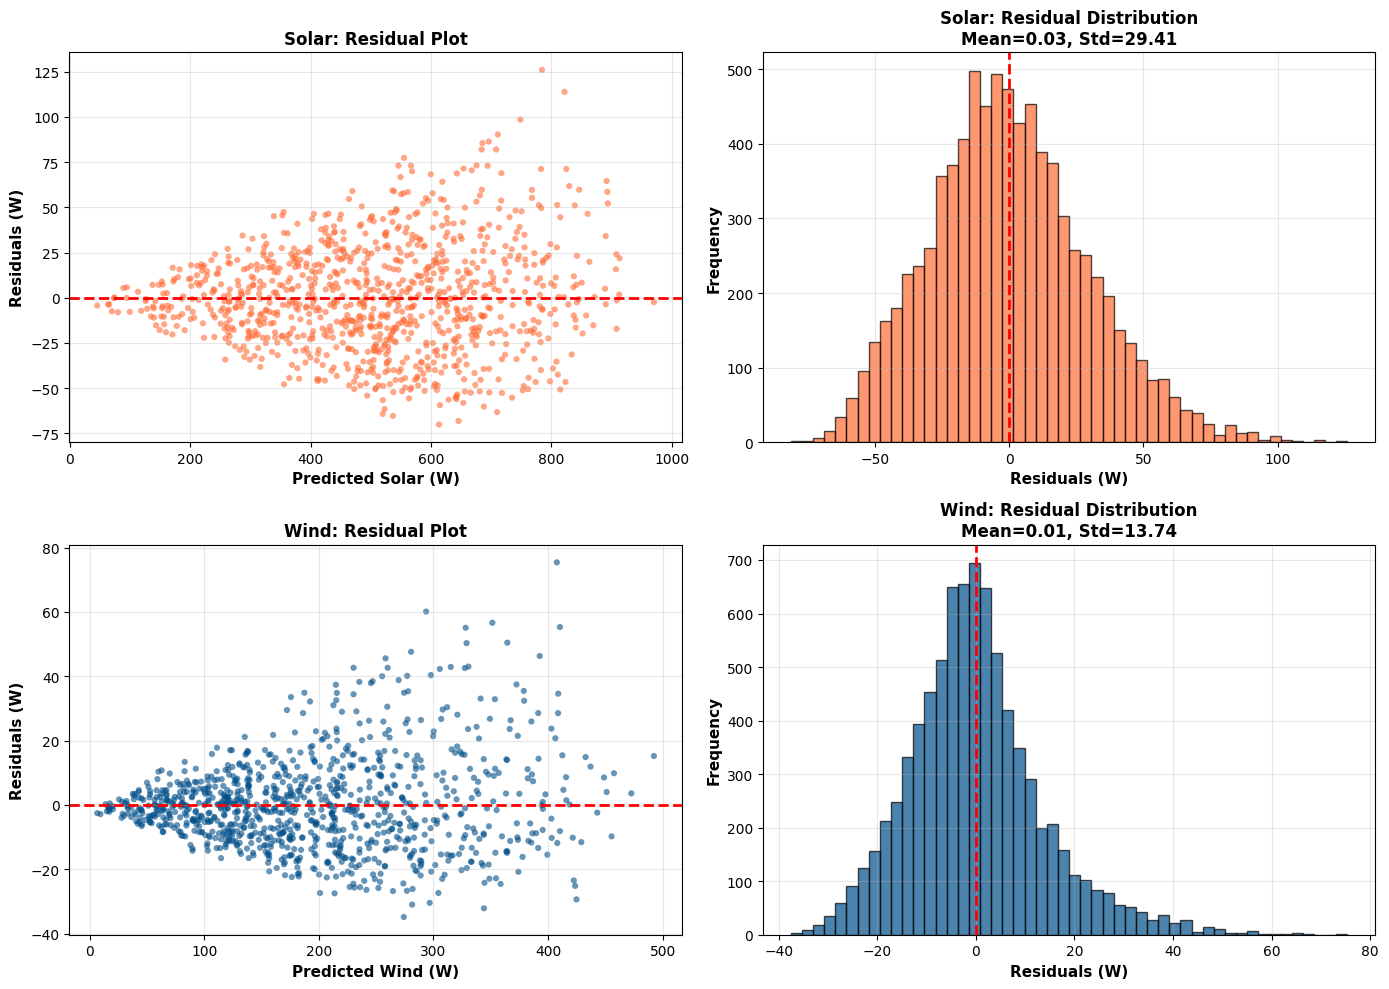

✓ Saved: onnx_residual_analysis.png

[6] Generating Plot 3: Error Distribution...


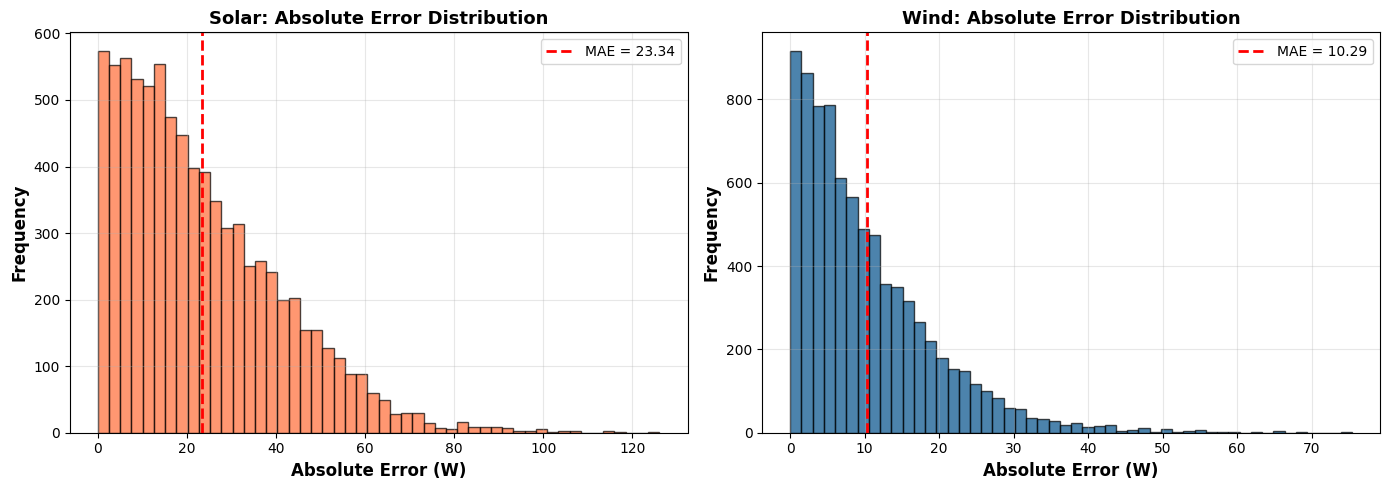

✓ Saved: onnx_error_distribution.png

[7] Generating Plot 4: Performance Metrics...


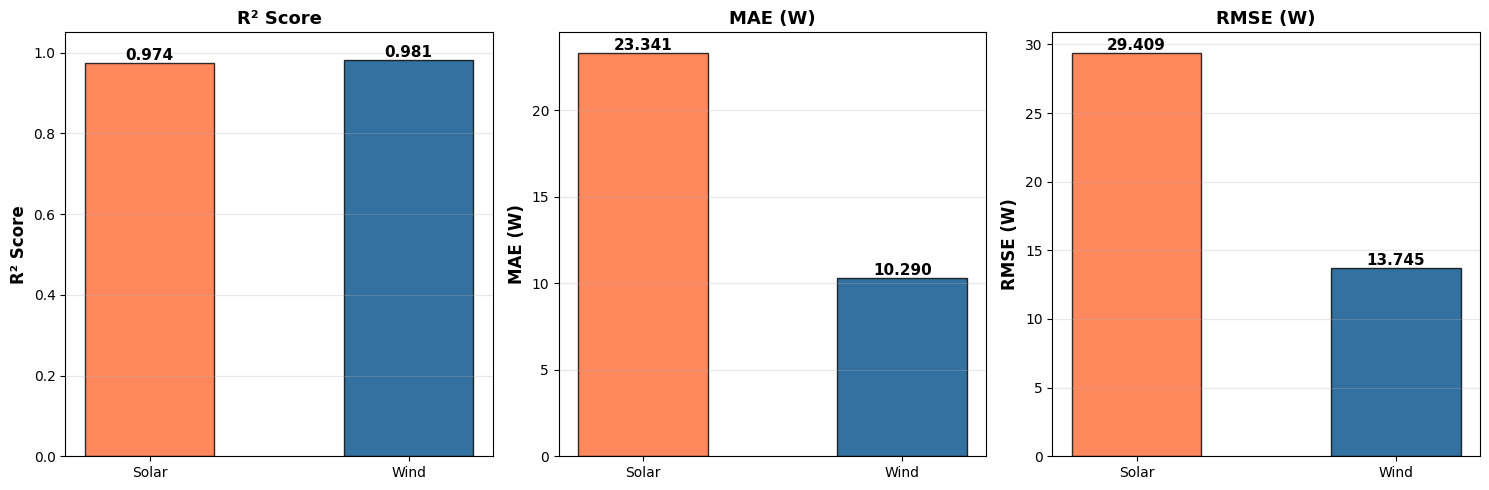

✓ Saved: onnx_performance_metrics.png

[8] Generating Plot 5: Accuracy by Output Range...


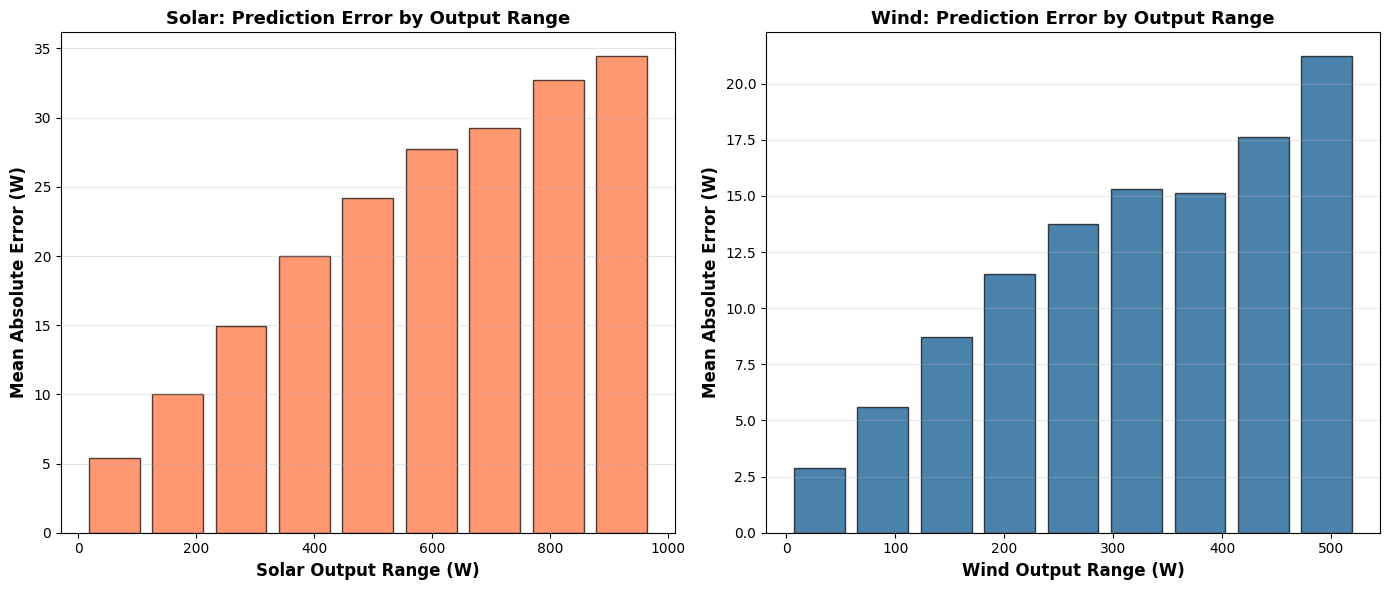

✓ Saved: onnx_accuracy_by_range.png

[9] Generating Plot 6: Energy Decision Analysis...


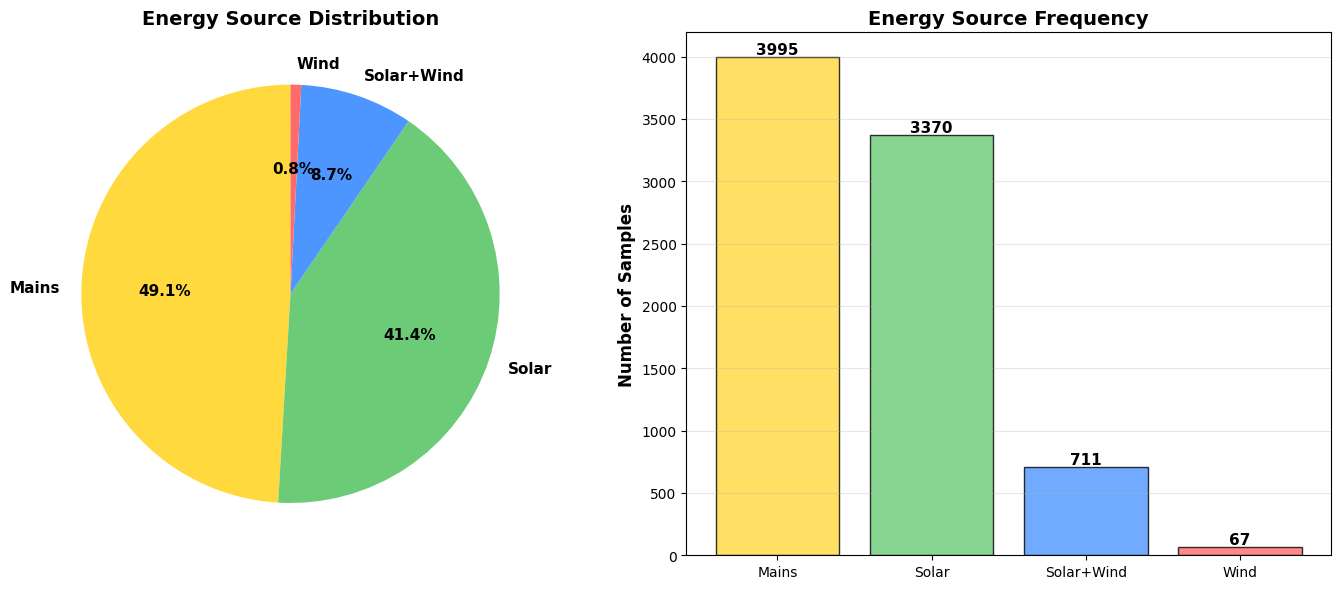

✓ Saved: onnx_energy_decisions.png

ALL PLOTS GENERATED SUCCESSFULLY!

Generated files:
  1. onnx_prediction_vs_actual.png - Prediction accuracy scatter plots
  2. onnx_residual_analysis.png - Error patterns and distributions
  3. onnx_error_distribution.png - Absolute error histograms
  4. onnx_performance_metrics.png - R², MAE, RMSE comparison
  5. onnx_accuracy_by_range.png - Error variation across output ranges
  6. onnx_energy_decisions.png - Energy source distribution analysis

MODEL PERFORMANCE SUMMARY:

Solar Output:
  R² Score: 0.9745
  MAE:      23.34 W
  RMSE:     29.41 W

Wind Output:
  R² Score: 0.9813
  MAE:      10.29 W
  RMSE:     13.74 W

Energy Decision Distribution:
  Mains       :   3995 (49.06%)
  Solar       :   3370 (41.39%)
  Solar+Wind  :    711 ( 8.73%)
  Wind        :     67 ( 0.82%)

VISUALIZATION COMPLETE!


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import onnxruntime as ort
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# ============================================
# CONFIGURATION FOR COLAB
# ============================================
%matplotlib inline
plt.style.use('default')

PLOT_SAMPLE = 1000  # Number of points to show in scatter plots

print("="*60)
print("GENERATING PLOTS FOR ONNX MODEL (Colab Optimized)")
print("="*60)

# ============================================
# PART 1: LOAD ONNX MODEL
# ============================================
print("\n[1] Loading ONNX model...")

onnx_file = 'energy_regression_model.onnx'

try:
    ort_session = ort.InferenceSession(onnx_file)
    input_name = ort_session.get_inputs()[0].name
    print(f"✓ ONNX model loaded from '{onnx_file}'")
except FileNotFoundError:
    print(f"✗ Error: '{onnx_file}' not found!")
    print("  Please upload the ONNX model file to Colab")
    exit()

# ============================================
# PART 2: LOAD DATASET
# ============================================
print("\n[2] Loading dataset...")

df = pd.read_csv('final_energy_dataset_2.csv')

features = [
    'Temperature', 'Humidity', 'Light', 'HumidityRatio',
    'light_out', 'humidity_solar_out', 'temperature_out',
    'wind_speed_out', 'atmp_out', 'humidity_wind_out',
    'Occupancy', 'main'
]

X = df[features].values.astype(np.float32)
y_solar = df['solar_output'].values
y_wind = df['wind_output'].values

print(f"✓ Dataset loaded: {len(df)} samples")

# ============================================
# PART 3: MAKE PREDICTIONS
# ============================================
print("\n[3] Making predictions with ONNX model...")

predictions = ort_session.run(None, {input_name: X})[0]
solar_pred = predictions[:, 0]
wind_pred = predictions[:, 1]

# Calculate metrics
solar_r2 = r2_score(y_solar, solar_pred)
wind_r2 = r2_score(y_wind, wind_pred)
solar_mae = mean_absolute_error(y_solar, solar_pred)
wind_mae = mean_absolute_error(y_wind, wind_pred)
solar_rmse = np.sqrt(mean_squared_error(y_solar, solar_pred))
wind_rmse = np.sqrt(mean_squared_error(y_wind, wind_pred))

print(f"✓ Predictions complete")
print(f"  Solar R²: {solar_r2:.4f}")
print(f"  Wind R²:  {wind_r2:.4f}")

# ============================================
# PLOT 1: PREDICTION VS ACTUAL
# ============================================
print("\n[4] Generating Plot 1: Prediction vs Actual...")

plot_idx = np.random.choice(len(df), min(PLOT_SAMPLE, len(df)), replace=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Solar
axes[0].scatter(y_solar[plot_idx], solar_pred[plot_idx],
                alpha=0.6, s=20, color='#FF6B35', edgecolors='none')
min_val, max_val = y_solar.min(), y_solar.max()
axes[0].plot([min_val, max_val], [min_val, max_val],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Solar Output (W)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Solar Output (W)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Solar: Predicted vs Actual\nR² = {solar_r2:.4f}',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Wind
axes[1].scatter(y_wind[plot_idx], wind_pred[plot_idx],
                alpha=0.6, s=20, color='#004E89', edgecolors='none')
min_val, max_val = y_wind.min(), y_wind.max()
axes[1].plot([min_val, max_val], [min_val, max_val],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Wind Output (W)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Wind Output (W)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Wind: Predicted vs Actual\nR² = {wind_r2:.4f}',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('onnx_prediction_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: onnx_prediction_vs_actual.png")

# ============================================
# PLOT 2: RESIDUAL ANALYSIS
# ============================================
print("\n[5] Generating Plot 2: Residual Analysis...")

solar_residuals = y_solar - solar_pred
wind_residuals = y_wind - wind_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Solar Residuals vs Predicted
axes[0, 0].scatter(solar_pred[plot_idx], solar_residuals[plot_idx],
                   alpha=0.6, s=20, color='#FF6B35', edgecolors='none')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Solar (W)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals (W)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Solar: Residual Plot', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Solar Residual Distribution
axes[0, 1].hist(solar_residuals, bins=50, color='#FF6B35', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals (W)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Solar: Residual Distribution\nMean={solar_residuals.mean():.2f}, Std={solar_residuals.std():.2f}',
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Wind Residuals vs Predicted
axes[1, 0].scatter(wind_pred[plot_idx], wind_residuals[plot_idx],
                   alpha=0.6, s=20, color='#004E89', edgecolors='none')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Wind (W)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Residuals (W)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Wind: Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Wind Residual Distribution
axes[1, 1].hist(wind_residuals, bins=50, color='#004E89', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals (W)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title(f'Wind: Residual Distribution\nMean={wind_residuals.mean():.2f}, Std={wind_residuals.std():.2f}',
                     fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('onnx_residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: onnx_residual_analysis.png")

# ============================================
# PLOT 3: ERROR DISTRIBUTION COMPARISON
# ============================================
print("\n[6] Generating Plot 3: Error Distribution...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Solar Error Distribution
solar_errors = np.abs(solar_residuals)
axes[0].hist(solar_errors, bins=50, color='#FF6B35', alpha=0.7, edgecolor='black')
axes[0].axvline(x=solar_mae, color='red', linestyle='--', linewidth=2,
                label=f'MAE = {solar_mae:.2f}')
axes[0].set_xlabel('Absolute Error (W)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Solar: Absolute Error Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Wind Error Distribution
wind_errors = np.abs(wind_residuals)
axes[1].hist(wind_errors, bins=50, color='#004E89', alpha=0.7, edgecolor='black')
axes[1].axvline(x=wind_mae, color='red', linestyle='--', linewidth=2,
                label=f'MAE = {wind_mae:.2f}')
axes[1].set_xlabel('Absolute Error (W)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Wind: Absolute Error Distribution', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('onnx_error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: onnx_error_distribution.png")

# ============================================
# PLOT 4: PERFORMANCE METRICS SUMMARY
# ============================================
print("\n[7] Generating Plot 4: Performance Metrics...")

metrics = {
    'Solar': {
        'R² Score': solar_r2,
        'MAE (W)': solar_mae,
        'RMSE (W)': solar_rmse
    },
    'Wind': {
        'R² Score': wind_r2,
        'MAE (W)': wind_mae,
        'RMSE (W)': wind_rmse
    }
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metric_names = ['R² Score', 'MAE (W)', 'RMSE (W)']
colors = ['#FF6B35', '#004E89']

for idx, metric in enumerate(metric_names):
    solar_val = metrics['Solar'][metric]
    wind_val = metrics['Wind'][metric]

    bars = axes[idx].bar(['Solar', 'Wind'], [solar_val, wind_val],
                         color=colors, alpha=0.8, edgecolor='black', width=0.5)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}', ha='center', va='bottom',
                      fontsize=11, fontweight='bold')

    axes[idx].set_ylabel(metric, fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{metric}', fontsize=13, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

    if metric == 'R² Score':
        axes[idx].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('onnx_performance_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: onnx_performance_metrics.png")

# ============================================
# PLOT 5: PREDICTION ACCURACY BY RANGE
# ============================================
print("\n[8] Generating Plot 5: Accuracy by Output Range...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Solar - binned by output range
solar_bins = np.linspace(y_solar.min(), y_solar.max(), 10)
solar_bin_centers = (solar_bins[:-1] + solar_bins[1:]) / 2
solar_bin_indices = np.digitize(y_solar, solar_bins) - 1
solar_mae_by_bin = [solar_errors[solar_bin_indices == i].mean()
                    for i in range(len(solar_bins)-1)]

axes[0].bar(solar_bin_centers, solar_mae_by_bin,
            width=(solar_bins[1]-solar_bins[0])*0.8,
            color='#FF6B35', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Solar Output Range (W)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Mean Absolute Error (W)', fontsize=12, fontweight='bold')
axes[0].set_title('Solar: Prediction Error by Output Range', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Wind - binned by output range
wind_bins = np.linspace(y_wind.min(), y_wind.max(), 10)
wind_bin_centers = (wind_bins[:-1] + wind_bins[1:]) / 2
wind_bin_indices = np.digitize(y_wind, wind_bins) - 1
wind_mae_by_bin = [wind_errors[wind_bin_indices == i].mean()
                   for i in range(len(wind_bins)-1)]

axes[1].bar(wind_bin_centers, wind_mae_by_bin,
            width=(wind_bins[1]-wind_bins[0])*0.8,
            color='#004E89', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Wind Output Range (W)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mean Absolute Error (W)', fontsize=12, fontweight='bold')
axes[1].set_title('Wind: Prediction Error by Output Range', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('onnx_accuracy_by_range.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: onnx_accuracy_by_range.png")

# ============================================
# PLOT 6: ENERGY DECISION ANALYSIS
# ============================================
print("\n[9] Generating Plot 6: Energy Decision Analysis...")

# Calculate energy decisions for all samples
def decide_energy_source(solar, wind, mains):
    total = solar + wind
    required = mains * 1.1
    if total >= required:
        if solar >= mains:
            return 'Solar'
        elif wind >= mains:
            return 'Wind'
        else:
            return 'Solar+Wind'
    else:
        return 'Mains'

# Get decisions for predictions
decisions = [decide_energy_source(solar_pred[i], wind_pred[i], df['main'].iloc[i])
             for i in range(len(df))]

# Count decisions
from collections import Counter
decision_counts = Counter(decisions)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
colors_pie = ['#FFD93D', '#6BCB77', '#4D96FF', '#FF6B6B']
axes[0].pie(decision_counts.values(), labels=decision_counts.keys(),
            autopct='%1.1f%%', startangle=90, colors=colors_pie,
            textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0].set_title('Energy Source Distribution', fontsize=14, fontweight='bold')

# Bar chart
bars = axes[1].bar(decision_counts.keys(), decision_counts.values(),
                   color=colors_pie, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
axes[1].set_title('Energy Source Frequency', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('onnx_energy_decisions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: onnx_energy_decisions.png")

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*60)
print("ALL PLOTS GENERATED SUCCESSFULLY!")
print("="*60)

print("\nGenerated files:")
print("  1. onnx_prediction_vs_actual.png - Prediction accuracy scatter plots")
print("  2. onnx_residual_analysis.png - Error patterns and distributions")
print("  3. onnx_error_distribution.png - Absolute error histograms")
print("  4. onnx_performance_metrics.png - R², MAE, RMSE comparison")
print("  5. onnx_accuracy_by_range.png - Error variation across output ranges")
print("  6. onnx_energy_decisions.png - Energy source distribution analysis")

print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY:")
print("="*60)

print(f"\nSolar Output:")
print(f"  R² Score: {solar_r2:.4f}")
print(f"  MAE:      {solar_mae:.2f} W")
print(f"  RMSE:     {solar_rmse:.2f} W")

print(f"\nWind Output:")
print(f"  R² Score: {wind_r2:.4f}")
print(f"  MAE:      {wind_mae:.2f} W")
print(f"  RMSE:     {wind_rmse:.2f} W")

print(f"\nEnergy Decision Distribution:")
for source, count in decision_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {source:12s}: {count:6d} ({percentage:5.2f}%)")

print("\n" + "="*60)
print("VISUALIZATION COMPLETE!")
print("="*60)

In [29]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx
import onnxruntime as ort
import json
import time

print("="*70)
print("COMPLETE TRAINING AND ONNX CONVERSION PIPELINE")
print("="*70)

# ============================================
# PART 1: LOAD AND PREPARE DATA
# ============================================
print("\n[1] Loading dataset...")

df = pd.read_csv('final_energy_dataset_2.csv')

features = [
    'Temperature', 'Humidity', 'Light', 'HumidityRatio',
    'light_out', 'humidity_solar_out', 'temperature_out',
    'wind_speed_out', 'atmp_out', 'humidity_wind_out',
    'Occupancy', 'main'
]

X = df[features]
y_reg = df[['solar_output', 'wind_output']]

print(f"✓ Dataset loaded: {len(df)} samples, {len(features)} features")
print(f"  Features: {features}")
print(f"  Targets: {list(y_reg.columns)}")

# ============================================
# PART 2: DEFINE HYPERPARAMETERS
# ============================================
print("\n[2] Setting optimized hyperparameters...")

best_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'subsample': 0.8,
    'random_state': 42
}

print("  Hyperparameters:")
for key, value in best_params.items():
    print(f"    {key}: {value}")

# ============================================
# PART 3: K-FOLD CROSS-VALIDATION
# ============================================
print("\n[3] Running 5-Fold Cross-Validation...")
print("-"*70)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

solar_r2_scores = []
wind_r2_scores = []
solar_mae_scores = []
wind_mae_scores = []

fold_num = 1
for train_idx, val_idx in kfold.split(X):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_reg.iloc[train_idx], y_reg.iloc[val_idx]

    # Train model
    fold_model = MultiOutputRegressor(GradientBoostingRegressor(**best_params))
    fold_model.fit(X_train, y_train)

    # Predict
    y_pred = fold_model.predict(X_val)

    # Calculate metrics
    solar_r2 = r2_score(y_val['solar_output'], y_pred[:, 0])
    wind_r2 = r2_score(y_val['wind_output'], y_pred[:, 1])
    solar_mae = mean_absolute_error(y_val['solar_output'], y_pred[:, 0])
    wind_mae = mean_absolute_error(y_val['wind_output'], y_pred[:, 1])

    solar_r2_scores.append(solar_r2)
    wind_r2_scores.append(wind_r2)
    solar_mae_scores.append(solar_mae)
    wind_mae_scores.append(wind_mae)

    print(f"Fold {fold_num}: Solar R²={solar_r2:.4f}, Wind R²={wind_r2:.4f}")
    fold_num += 1

print("\n" + "="*70)
print("CROSS-VALIDATION RESULTS")
print("="*70)
print(f"Solar  - R²: {np.mean(solar_r2_scores):.4f} ± {np.std(solar_r2_scores):.4f}")
print(f"         MAE: {np.mean(solar_mae_scores):.2f} ± {np.std(solar_mae_scores):.2f} W")
print(f"Wind   - R²: {np.mean(wind_r2_scores):.4f} ± {np.std(wind_r2_scores):.4f}")
print(f"         MAE: {np.mean(wind_mae_scores):.2f} ± {np.std(wind_mae_scores):.2f} W")

# ============================================
# PART 4: TRAIN FINAL MODEL ON FULL DATASET
# ============================================
print("\n[4] Training final model on full dataset...")

final_model = MultiOutputRegressor(GradientBoostingRegressor(**best_params))

train_start = time.time()
final_model.fit(X, y_reg)
train_time = time.time() - train_start

print(f"✓ Model trained successfully in {train_time:.2f} seconds")

# Evaluate on full dataset (training performance)
predictions = final_model.predict(X)
solar_pred = predictions[:, 0]
wind_pred = predictions[:, 1]

solar_r2_full = r2_score(y_reg['solar_output'], solar_pred)
wind_r2_full = r2_score(y_reg['wind_output'], wind_pred)
solar_mae_full = mean_absolute_error(y_reg['solar_output'], solar_pred)
wind_mae_full = mean_absolute_error(y_reg['wind_output'], wind_pred)
solar_rmse_full = np.sqrt(mean_squared_error(y_reg['solar_output'], solar_pred))
wind_rmse_full = np.sqrt(mean_squared_error(y_reg['wind_output'], wind_pred))

print("\nFinal Model Performance (on training data):")
print(f"  Solar - R²: {solar_r2_full:.4f}, MAE: {solar_mae_full:.2f} W, RMSE: {solar_rmse_full:.2f} W")
print(f"  Wind  - R²: {wind_r2_full:.4f}, MAE: {wind_mae_full:.2f} W, RMSE: {wind_rmse_full:.2f} W")

# ============================================
# PART 5: SAVE SCIKIT-LEARN MODEL
# ============================================
print("\n[5] Saving scikit-learn model...")

joblib.dump(final_model, 'energy_regression_model.pkl')
joblib.dump(best_params, 'best_hyperparameters.pkl')

print("✓ Saved: energy_regression_model.pkl")
print("✓ Saved: best_hyperparameters.pkl")

# ============================================
# PART 6: CONVERT TO ONNX
# ============================================
print("\n[6] Converting model to ONNX format...")

# Define input type
initial_type = [('float_input', FloatTensorType([None, len(features)]))]

# Convert to ONNX
try:
    onnx_model = convert_sklearn(
        final_model,
        initial_types=initial_type,
        target_opset=12
    )

    # Save ONNX model
    onnx_file = 'energy_regression_model.onnx'
    with open(onnx_file, "wb") as f:
        f.write(onnx_model.SerializeToString())

    print(f"✓ ONNX model saved as '{onnx_file}'")

    # Validate ONNX model
    onnx.checker.check_model(onnx_model)
    print("✓ ONNX model validated successfully")

except Exception as e:
    print(f"✗ ONNX conversion failed: {e}")
    print("  Note: Install with: pip install skl2onnx onnx onnxruntime")
    onnx_file = None

# ============================================
# PART 7: VERIFY ONNX MODEL
# ============================================
if onnx_file:
    print("\n[7] Verifying ONNX model predictions...")

    # Create ONNX Runtime session
    ort_session = ort.InferenceSession(onnx_file)
    input_name = ort_session.get_inputs()[0].name

    # Test samples
    test_sample = X.iloc[0:1].values.astype(np.float32)

    # scikit-learn prediction
    sklearn_pred = final_model.predict(test_sample)

    # ONNX prediction
    onnx_pred = ort_session.run(None, {input_name: test_sample})[0]

    # Compare
    solar_diff = abs(sklearn_pred[0][0] - onnx_pred[0][0])
    wind_diff = abs(sklearn_pred[0][1] - onnx_pred[0][1])

    print(f"\nPrediction Comparison (Sample 1):")
    print(f"  Solar - sklearn: {sklearn_pred[0][0]:.4f}, ONNX: {onnx_pred[0][0]:.4f}, Diff: {solar_diff:.6f}")
    print(f"  Wind  - sklearn: {sklearn_pred[0][1]:.4f}, ONNX: {onnx_pred[0][1]:.4f}, Diff: {wind_diff:.6f}")

    if solar_diff < 0.01 and wind_diff < 0.01:
        print("✓ ONNX model predictions match scikit-learn (within 0.01 tolerance)")
    else:
        print("⚠ Warning: ONNX predictions differ from scikit-learn")

# ============================================
# PART 8: BENCHMARK PERFORMANCE
# ============================================
print("\n[8] Benchmarking inference performance...")

# Prepare test batch
batch_size = 100
test_batch_pd = X.iloc[:batch_size]
test_batch_np = test_batch_pd.values.astype(np.float32)

# Benchmark scikit-learn
iterations = 100
start = time.time()
for _ in range(iterations):
    _ = final_model.predict(test_batch_pd)
sklearn_time = (time.time() - start) / iterations

print(f"\nscikit-learn (batch of {batch_size}):")
print(f"  Average time: {sklearn_time*1000:.2f} ms")
print(f"  Throughput:   {batch_size/sklearn_time:.0f} predictions/second")

# Benchmark ONNX
if onnx_file:
    start = time.time()
    for _ in range(iterations):
        _ = ort_session.run(None, {input_name: test_batch_np})
    onnx_time = (time.time() - start) / iterations

    print(f"\nONNX Runtime (batch of {batch_size}):")
    print(f"  Average time: {onnx_time*1000:.2f} ms")
    print(f"  Throughput:   {batch_size/onnx_time:.0f} predictions/second")
    print(f"  Speedup:      {sklearn_time/onnx_time:.2f}x faster")

# ============================================
# PART 9: SAVE METADATA
# ============================================
print("\n[9] Saving model metadata...")

metadata = {
    'model_info': {
        'name': 'Energy Prediction Model',
        'version': '1.0',
        'type': 'Gradient Boosting Regressor',
        'framework': 'scikit-learn',
        'outputs': ['solar_output', 'wind_output']
    },
    'hyperparameters': best_params,
    'features': {
        'names': features,
        'count': len(features),
        'types': {
            'indoor_environmental': ['Temperature', 'Humidity', 'Light', 'HumidityRatio'],
            'outdoor_environmental': ['light_out', 'humidity_solar_out', 'temperature_out',
                                     'wind_speed_out', 'atmp_out', 'humidity_wind_out'],
            'operational': ['Occupancy', 'main']
        }
    },
    'training_info': {
        'dataset_size': len(df),
        'training_time_seconds': train_time,
        'cross_validation': '5-fold',
        'cv_results': {
            'solar_r2_mean': float(np.mean(solar_r2_scores)),
            'solar_r2_std': float(np.std(solar_r2_scores)),
            'wind_r2_mean': float(np.mean(wind_r2_scores)),
            'wind_r2_std': float(np.std(wind_r2_scores))
        }
    },
    'performance': {
        'solar': {
            'r2': float(solar_r2_full),
            'mae': float(solar_mae_full),
            'rmse': float(solar_rmse_full)
        },
        'wind': {
            'r2': float(wind_r2_full),
            'mae': float(wind_mae_full),
            'rmse': float(wind_rmse_full)
        }
    },
    'feature_importance': {
        'solar': {
            feature: float(importance)
            for feature, importance in zip(features, final_model.estimators_[0].feature_importances_)
        },
        'wind': {
            feature: float(importance)
            for feature, importance in zip(features, final_model.estimators_[1].feature_importances_)
        }
    },
    'energy_decision_logic': {
        'safety_margin': 1.1,
        'description': 'Total renewable must be >= 1.1x mains demand to use eco sources'
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Saved: model_metadata.json")

# ============================================
# PART 10: FILE SIZE SUMMARY
# ============================================
print("\n[10] Model file sizes:")

import os

files = [
    'energy_regression_model.pkl',
    'best_hyperparameters.pkl',
    'model_metadata.json'
]

if onnx_file:
    files.append(onnx_file)

for file in files:
    if os.path.exists(file):
        size = os.path.getsize(file)
        if size > 1024*1024:
            print(f"  {file}: {size/(1024*1024):.2f} MB")
        elif size > 1024:
            print(f"  {file}: {size/1024:.2f} KB")
        else:
            print(f"  {file}: {size} bytes")

# ============================================
# PART 11: TEST WITH SAMPLE PREDICTIONS
# ============================================
print("\n[11] Testing with sample scenarios...")
print("-"*70)

test_scenarios = [
    {
        'name': 'High Solar (Sunny Day)',
        'data': [25.0, 45.0, 500.0, 0.005, 800.0, 350.0, 28.0, 3.5, 1013.0, 140.0, 1, 50.0],
        'mains': 50.0
    },
    {
        'name': 'High Wind (Windy Day)',
        'data': [18.0, 70.0, 150.0, 0.008, 200.0, 140.0, 15.0, 12.0, 1008.0, 840.0, 3, 200.0],
        'mains': 200.0
    },
    {
        'name': 'Low Renewable (Night)',
        'data': [22.0, 55.0, 0.0, 0.006, 0.0, 0.0, 20.0, 1.0, 1012.0, 55.0, 2, 180.0],
        'mains': 180.0
    }
]

def decide_energy_source(solar, wind, mains):
    total = solar + wind
    required = mains * 1.1
    if total >= required:
        if solar >= mains:
            return 'Solar'
        elif wind >= mains:
            return 'Wind'
        else:
            return 'Solar+Wind'
    return 'Mains'

for scenario in test_scenarios:
    test_data = np.array([scenario['data']])
    pred = final_model.predict(test_data)
    solar = pred[0][0]
    wind = pred[0][1]
    decision = decide_energy_source(solar, wind, scenario['mains'])

    print(f"\n{scenario['name']}:")
    print(f"  Demand: {scenario['mains']:.1f}W | Solar: {solar:.1f}W | Wind: {wind:.1f}W")
    print(f"  Decision: Use {decision}")

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*70)
print("TRAINING AND CONVERSION COMPLETE!")
print("="*70)

print("\n✓ Model trained with optimized hyperparameters")
print("✓ 5-fold cross-validation completed")
print("✓ Model saved in PKL format")
if onnx_file:
    print("✓ Model converted to ONNX format")
    print("✓ ONNX model verified and benchmarked")
print("✓ Metadata and configurations saved")

print("\n" + "="*70)
print("GENERATED FILES:")
print("="*70)
print("  1. energy_regression_model.pkl     - scikit-learn model")
print("  2. energy_regression_model.onnx    - ONNX model")
print("  3. best_hyperparameters.pkl        - Model configuration")
print("  4. model_metadata.json             - Complete metadata")

print("\n" + "="*70)
print("NEXT STEPS:")
print("="*70)
print("  • Test the model with your own data")
print("  • Deploy using ONNX for production")
print("  • Monitor performance and retrain periodically")
print("  • Generate visualizations with plotting scripts")

print("\n" + "="*70)

COMPLETE TRAINING AND ONNX CONVERSION PIPELINE

[1] Loading dataset...
✓ Dataset loaded: 8143 samples, 12 features
  Features: ['Temperature', 'Humidity', 'Light', 'HumidityRatio', 'light_out', 'humidity_solar_out', 'temperature_out', 'wind_speed_out', 'atmp_out', 'humidity_wind_out', 'Occupancy', 'main']
  Targets: ['solar_output', 'wind_output']

[2] Setting optimized hyperparameters...
  Hyperparameters:
    n_estimators: 200
    learning_rate: 0.05
    max_depth: 5
    min_samples_split: 10
    min_samples_leaf: 4
    subsample: 0.8
    random_state: 42

[3] Running 5-Fold Cross-Validation...
----------------------------------------------------------------------
Fold 1: Solar R²=0.9620, Wind R²=0.9718
Fold 2: Solar R²=0.9638, Wind R²=0.9707
Fold 3: Solar R²=0.9654, Wind R²=0.9691
Fold 4: Solar R²=0.9613, Wind R²=0.9743
Fold 5: Solar R²=0.9656, Wind R²=0.9730

CROSS-VALIDATION RESULTS
Solar  - R²: 0.9636 ± 0.0018
         MAE: 27.85 ± 0.60 W
Wind   - R²: 0.9718 ± 0.0018
         MAE